In [102]:
!pip install pandas openpyxl matplotlib numpy scikit-learn seaborn statsmodels imbalanced-learn
!pip install pyclustering

     ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
     ---------------------------------------- 2.6/2.6 MB 36.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395132 sha256=8bf770cde26afa05ee0e13789165e7f86dbfa6ab69471ee5b35d1631391d76ef
  Stored in directory: c:\users\admaz\appdata\local\pip\cache\wheels\68\29\b4\131bd7deec3663cc311ab9aa64d6517c3e3ec24bcadfc32f74
Successfully built pyclustering


In [224]:
# Importación de bibliotecas de manejo de datos
import pandas as pd
import openpyxl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Configuración de visualización de gráficos
%matplotlib inline
pd.set_option('display.float_format', '{:.2f}'.format)  # Evitar notación científica

# Estadísticas y pruebas estadísticas
import scipy.stats as stats
from scipy.stats import chi2_contingency, pointbiserialr
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Preprocesamiento y manejo de datos
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Modelos de clasificación
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Evaluación y métricas
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.metrics import silhouette_score

# Balance de clases
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

# Modelos de reducción de dimensionalidad
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Clustering
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from pyclustering.cluster.kmedoids import kmedoids

# MLY0100: Evaluación Parcial Nº3
* CARLA FRANCISCA SEPULVEDA MEYNARD
* MADELAINE STEPHANIE ESCOBAR DURAN
* ADOLFO ANDRES MAZA PENA


# 1. Comprensión del negocio

En el contexto del análisis de datos y la segmentación de clientes, el objetivo principal es identificar patrones y grupos de comportamiento dentro de un conjunto de datos. Este tipo de análisis resulta especialmente valioso cuando no se cuenta con etiquetas predefinidas para los datos y se requiere descubrir por sí mismo las relaciones y estructuras subyacentes. El uso de técnicas de modelado no supervisado, como el clustering, permite identificar grupos naturales dentro de los datos, lo que puede llevar a una mejor comprensión del comportamiento de los individuos, clientes o eventos que se están analizando.

En este caso particular, *el análisis se centra en la segmentación de un conjunto de variables sin una etiqueta de clase definida*. **La segmentación permite clasificar a los individuos o eventos en grupos que comparten características similares**, lo que podría ser útil para estrategias de marketing, optimización de recursos o personalización de servicios. Además, **mediante el uso de varias técnicas de clustering, se busca identificar cuál de estos enfoques proporciona los resultados más coherentes y útiles en términos de homogeneidad dentro de los grupos y separación entre ellos**.

Al aplicar métodos de clustering como K-Means, K-Medoids, DBSCAN y clustering jerárquico, se pretende descubrir patrones ocultos dentro de los datos que podrían no ser evidentes a simple vista. Estos modelos permiten segmentar el conjunto de datos en clústeres significativos, los cuales pueden ser utilizados para tomar decisiones informadas sobre la agrupación y el tratamiento de diferentes segmentos.

El análisis busca, por tanto, no solo segmentar el conjunto de datos, sino también proporcionar una comprensión más profunda de la estructura del negocio o fenómeno que está siendo modelado. Los resultados de este proceso pueden ser aplicables a la toma de decisiones estratégicas, como la mejora de la segmentación de clientes, la identificación de perfiles de comportamiento, o la optimización de recursos y procesos dentro de la organización. 

# 2. Comprensión de datos


## 2.1 Recolección de datos

In [3]:
# Acceso a documentos en drive

#from google.colab import drive
#drive.mount('/content/drive')

In [74]:
# Carga de documento excel

try:
    archivo_excel = "Base_clientes_Monopoly.xlsx"  # Cambia esto por el nombre correcto
    df = pd.read_excel(archivo_excel, sheet_name=0, nrows=10000, skiprows=1) ## Selección de 10000 casos de la primera hoja con columnas elegidas y omisión de primera fila
    print("Archivo cargado exitosamente")
except Exception as e:
    print(f"Error al cargar el archivo: {e}")

Archivo cargado exitosamente


Para la selección correcta de los features de los modelos a desarrollar, la primera decisión fue realizar una serie de correlaciones entre posibles características continuas. Se empleo la prueba de chi-cuadrado para esta labor.

In [75]:
# Asegúrate de que esta es lA variable objetivo
target2 = df['target']

correlaciones = {}

variables_continuas = [
    'CUPO_L1', 'CUPO_MX', 'CUPO_L2', 'Col_T12', 'ColL1TE_T12',
    'EeccInt_T12', 'EeccNac_T12', 'Fac_T12', 'FacAI_T12',
    'FacAN_T12', 'FacCCOT_T12', 'FacCCPC_T12', 'FacCI_T12',
    'FacCN_T12', 'FacCOL_T12', 'FacDebAtm_T12', 'FacDebCom_T12',
    'FacPAT_T12', 'FlgAct_T12', 'FlgActAI_T12', 'FlgActAN_T12',
    'FlgActCCOT_T12', 'FlgActCCPC_T12', 'FlgActCI_T12',
    'FlgActCN_T12', 'FlgActCOL_T12', 'FlgActPAT_T12',
    'PagoInt_T12', 'PagoNac_T12', 'Txs_T12', 'TxsAI_T12',
    'TxsAN_T12', 'TxsCCOT_T12', 'TxsCCPC_T12', 'TxsCI_T12',
    'TxsCN_T12', 'TxsCOL_T12', 'TxsDebAtm_T12', 'TxsDebCom_T12',
    'TxsPAT_T12', 'UsoL1_T12', 'UsoL2_T12'
]

# Calcular la correlación para cada variable continua con For
for variable in variables_continuas:
    # Filtrar el DataFrame para que solo contenga filas sin NaN en la variable continua y en target
    data = df[[variable, 'target']].dropna()

    # Verificar que haya datos suficientes después de eliminar NaN
    if len(data) > 1:  # Se necesita al menos dos datos para calcular la correlación
        correlacion, p_value = pointbiserialr(data['target'], data[variable])  # Técnica biserial
        correlaciones[variable] = {
            'Correlación': correlacion,
            'p-value': p_value
        }
    else:
        correlaciones[variable] = {
            'Correlación': None,
            'p-value': None
        }

# Convertir el diccionario a un DataFrame para una mejor visualización
correlaciones_df = pd.DataFrame(correlaciones).T
print(correlaciones_df)


                Correlación  p-value
CUPO_L1               -0.06     0.00
CUPO_MX               -0.04     0.00
CUPO_L2                0.02     0.06
Col_T12                0.05     0.00
ColL1TE_T12            0.06     0.00
EeccInt_T12            0.03     0.01
EeccNac_T12            0.06     0.00
Fac_T12                0.03     0.01
FacAI_T12             -0.00     0.96
FacAN_T12              0.01     0.58
FacCCOT_T12            0.01     0.56
FacCCPC_T12            0.02     0.08
FacCI_T12              0.02     0.13
FacCN_T12              0.02     0.03
FacCOL_T12            -0.01     0.35
FacDebAtm_T12         -0.08     0.00
FacDebCom_T12         -0.08     0.00
FacPAT_T12             0.01     0.41
FlgAct_T12             0.02     0.02
FlgActAI_T12           0.00     0.91
FlgActAN_T12           0.01     0.39
FlgActCCOT_T12         0.05     0.00
FlgActCCPC_T12         0.03     0.00
FlgActCI_T12           0.01     0.26
FlgActCN_T12           0.01     0.49
FlgActCOL_T12         -0.00     0.70
F

In [76]:
contingency_table1 = pd.crosstab(df['target'], df['Sexo'])

# Calcular el estadístico Chi-cuadrado
chi2, p, dof, expected = chi2_contingency(contingency_table1)

# Calcular el coeficiente de Phi
phi = np.sqrt(chi2 / df.shape[0])

print("Coeficiente de Phi:", phi)

Coeficiente de Phi: 0.021039487903838174


In [77]:
contingency_table2 = pd.crosstab(df['target'], df['Region'])

# Calcular el estadístico Chi-cuadrado
chi2, p, dof, expected = chi2_contingency(contingency_table2)

# Calcular el coeficiente de Phi
phi = np.sqrt(chi2 / df.shape[0])

print("Coeficiente de Phi:", phi)

Coeficiente de Phi: 0.029188143372577312


A partir de la información generada, se observan una serie de variables apropiadas para las técnicas de modelos no supervisados:

*   EeccNac_T12: Monto nacional exigido en el estado de cuenta del cliente en el mes X
*   Fac_T12: Monto facturado por el cliente en TC en el mes X
*   Col_T12: Colocacion del cliente en TC en el mes X
*   UsoL1_T12: Monto de deuda en la linea de compras en la TC en el mes X

Ahora se va a realizar un análisis preliminar descriptivo de las variables preseleccionadas.




### 2.2 Análisis de los datos

#### 2.2.1 Análisis de variable característica 'EeccNac_T12'

Casos perdidos en EeccNac_T12: 1245
Estadísticos descriptivos para la variable 'EeccNac_T12':
Media: 211970.9279268989
Mediana: 86815.0
Moda: 0.0
Desviación Estándar: 326148.11228181096
Varianza: 106372591144.98875
Valor Mínimo: -1303628.0
Valor Máximo: 3529565.0
Percentil 25: 17408.0
Percentil 50 (Mediana): 86815.0
Percentil 75: 271541.0
-------------------------------------------------------


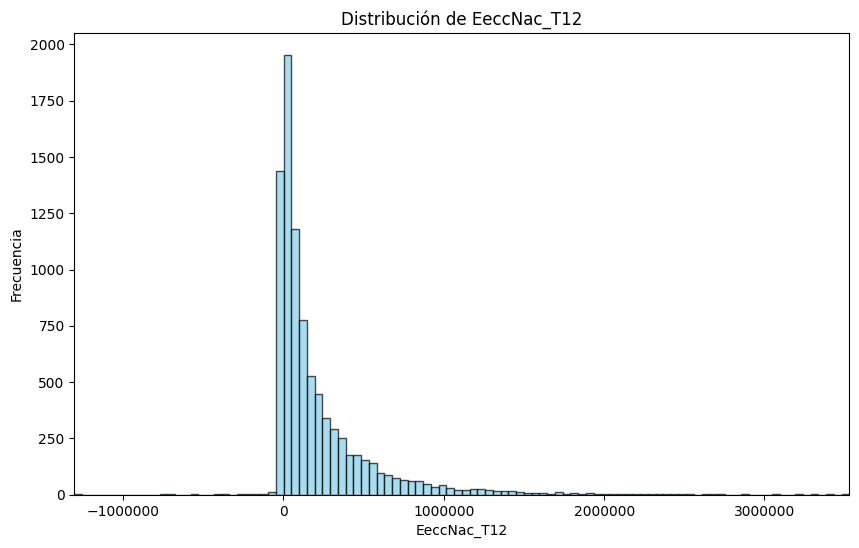

In [81]:
## Estadísticos de EeccNac_T12
casos_perdidos_eecc = df['EeccNac_T12'].isna().sum()
print(f'Casos perdidos en EeccNac_T12: {casos_perdidos_eecc}')
EeccNac_T12 = df['EeccNac_T12']
media = EeccNac_T12.mean()
mediana = EeccNac_T12.median()
moda = EeccNac_T12.mode()[0]  # La moda puede tener más de un valor, se toma el primero
desviacion_estandar = EeccNac_T12.std()
varianza = EeccNac_T12.var()
valor_minimo = EeccNac_T12.min()
valor_maximo = EeccNac_T12.max()
percentil_25 = EeccNac_T12.quantile(0.25)
percentil_50 = EeccNac_T12.quantile(0.50)  #  mediana
percentil_75 = EeccNac_T12.quantile(0.75)
# Mostrar los resultados
print("Estadísticos descriptivos para la variable 'EeccNac_T12':")
print(f"Media: {media}")
print(f"Mediana: {mediana}")
print(f"Moda: {moda}")
print(f"Desviación Estándar: {desviacion_estandar}")
print(f"Varianza: {varianza}")
print(f"Valor Mínimo: {valor_minimo}")
print(f"Valor Máximo: {valor_maximo}")
print(f"Percentil 25: {percentil_25}")
print(f"Percentil 50 (Mediana): {percentil_50}")
print(f"Percentil 75: {percentil_75}")
print("-------------------------------------------------------")

## Histograma de EeccNac_T12

plt.figure(figsize=(10, 6))
plt.hist(EeccNac_T12, bins=100, color='skyblue', edgecolor='black',  alpha=0.7)  # Ajustar 'bins' según el nivel de detalle que desees

plt.title('Distribución de EeccNac_T12')
plt.xlabel('EeccNac_T12')
plt.ylabel('Frecuencia')
plt.xlim([valor_minimo, valor_maximo])
plt.ticklabel_format(style='plain', axis='x')
plt.show()

El análisis descriptivo de la variable EeccNac_T12 muestra una distribución con los siguientes aspectos clave: 
* La media es 211,970.93, significativamente mayor que la mediana (86,815) y la moda (0.0), lo que indica una distribución sesgada hacia valores altos.
* La desviación estándar es alta (326,148.11), lo que refleja una gran variabilidad en los datos.
* existe asimetría, pues mientras el 25% de los datos está por debajo de 17,408, el 75% se sitúa por debajo de 271,541. 
* La presencia de los missing values se observa en la concentración en torno a valores bajos o nulo mediante la diferencia marcada entre media y mediana.

La presencia de valores outliers y perdidos implica el empleo de la transformación y limpieza de la variable

#### 2.2.2 Análisis de variable característica 'Fac_T12'

Casos perdidos en Fac_T12: 1245
Estadísticos descriptivos para la variable 'Fac_T12':
Media: 74667.45079640204
Mediana: 26217.0
Moda: 0.0
Desviación Estándar: 141439.9282401439
Varianza: 20005253300.577053
Valor Mínimo: -39593.0
Valor Máximo: 4631740.5859
Percentil 25: 0.0
Percentil 50 (Mediana): 26217.0
Percentil 75: 93885.0
-------------------------------------------------------


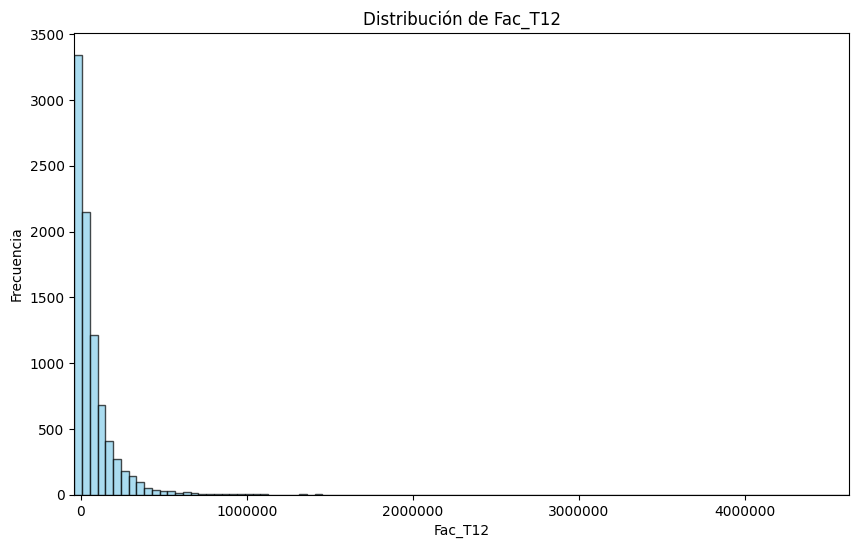

In [82]:
## Estadísticos de Fac_T12
casos_perdidos_Fac_T12 = df['Fac_T12'].isna().sum()
print(f'Casos perdidos en Fac_T12: {casos_perdidos_Fac_T12}')
Fac_T12 = df['Fac_T12']
media = Fac_T12.mean()
mediana = Fac_T12.median()
moda = Fac_T12.mode()[0]  # La moda puede tener más de un valor, se toma el primero
desviacion_estandar = Fac_T12.std()
varianza = Fac_T12.var()
valor_minimo = Fac_T12.min()
valor_maximo = Fac_T12.max()
percentil_25 = Fac_T12.quantile(0.25)
percentil_50 = Fac_T12.quantile(0.50)  #  mediana
percentil_75 = Fac_T12.quantile(0.75)
# Mostrar los resultados
print("Estadísticos descriptivos para la variable 'Fac_T12':")
print(f"Media: {media}")
print(f"Mediana: {mediana}")
print(f"Moda: {moda}")
print(f"Desviación Estándar: {desviacion_estandar}")
print(f"Varianza: {varianza}")
print(f"Valor Mínimo: {valor_minimo}")
print(f"Valor Máximo: {valor_maximo}")
print(f"Percentil 25: {percentil_25}")
print(f"Percentil 50 (Mediana): {percentil_50}")
print(f"Percentil 75: {percentil_75}")
print("-------------------------------------------------------")

## Histograma de Fac_T12

plt.figure(figsize=(10, 6))
plt.hist(Fac_T12, bins=100, color='skyblue', edgecolor='black',  alpha=0.7)  # Ajustar 'bins' según el nivel de detalle que desees

plt.title('Distribución de Fac_T12')
plt.xlabel('Fac_T12')
plt.ylabel('Frecuencia')
plt.xlim([valor_minimo, valor_maximo])
plt.ticklabel_format(style='plain', axis='x')
plt.show()

El análisis descriptivo de la variable Fac_T12 muestra una distribución con los siguientes aspectos clave:

* La media es 74,667.45, significativamente mayor que la mediana (26,217) y la moda (0.0), lo que indica una distribución sesgada hacia valores altos.
* La desviación estándar es alta (141,439.93), lo que refleja una gran variabilidad en los datos.
* Existe asimetría, pues mientras el 25% de los datos está por debajo de 0.0, el 75% se sitúa por debajo de 93,885.
* La presencia de los missing values se observa en la concentración en torno a valores bajos o nulos, como se evidencia en la diferencia marcada entre media y mediana.

La presencia de valores outliers y 1,245 casos perdidos implica el empleo de la transformación y limpieza de la variable.

#### 2.2.3 Análisis de variable característica 'Col_T12'

Casos perdidos en UsoL1_T12: 1245
Estadísticos descriptivos para la variable 'Col_T12':
Media: 326809.4152495717
Mediana: 125872.96
Moda: 0.0
Desviación Estándar: 611929.1275720178
Varianza: 374457257171.05084
Valor Mínimo: 0.0
Valor Máximo: 10493610.41
Percentil 25: 26995.0
Percentil 50 (Mediana): 125872.96
Percentil 75: 376682.0
-------------------------------------------------------


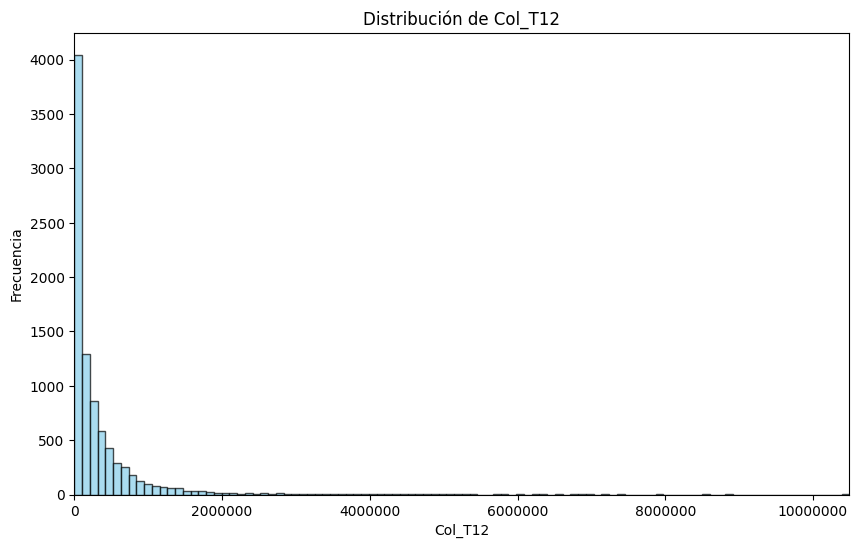

In [83]:
## Estadísticos de Col_T12
casos_perdidos_Col_T12 = df['Col_T12'].isna().sum()
print(f'Casos perdidos en UsoL1_T12: {casos_perdidos_Col_T12}')
Col_T12 = df['Col_T12']
media =Col_T12.mean()
mediana = Col_T12.median()
moda = Col_T12.mode()[0]  # La moda puede tener más de un valor, se toma el primero
desviacion_estandar = Col_T12.std()
varianza = Col_T12.var()
valor_minimo = Col_T12.min()
valor_maximo = Col_T12.max()
percentil_25 = Col_T12.quantile(0.25)
percentil_50 = Col_T12.quantile(0.50)  #  mediana
percentil_75 = Col_T12.quantile(0.75)
# Mostrar los resultados
print("Estadísticos descriptivos para la variable 'Col_T12':")
print(f"Media: {media}")
print(f"Mediana: {mediana}")
print(f"Moda: {moda}")
print(f"Desviación Estándar: {desviacion_estandar}")
print(f"Varianza: {varianza}")
print(f"Valor Mínimo: {valor_minimo}")
print(f"Valor Máximo: {valor_maximo}")
print(f"Percentil 25: {percentil_25}")
print(f"Percentil 50 (Mediana): {percentil_50}")
print(f"Percentil 75: {percentil_75}")
print("-------------------------------------------------------")

## Histograma de Col_T12

plt.figure(figsize=(10, 6))
plt.hist(Col_T12, bins=100, color='skyblue', edgecolor='black',  alpha=0.7)  # Ajustar 'bins' según el nivel de detalle que desees

plt.title('Distribución de Col_T12')
plt.xlabel('Col_T12')
plt.ylabel('Frecuencia')
plt.xlim([valor_minimo, valor_maximo])
plt.ticklabel_format(style='plain', axis='x')
plt.show()

El análisis descriptivo de la variable Col_T12 muestra una distribución con los siguientes aspectos clave:

* La media es 326,809.42, significativamente mayor que la mediana (125,872.96) y la moda (0.0), lo que indica una distribución sesgada hacia valores altos.
* La desviación estándar es alta (611,929.13), lo que refleja una gran variabilidad en los datos.
* Existe asimetría, pues mientras el 25% de los datos está por debajo de 26,995.0, el 75% se sitúa por debajo de 376,682.0.
* La presencia de los missing values se observa en la concentración en torno a valores bajos o nulos, destacada por la diferencia marcada entre media y mediana.

La presencia de valores outliers y 1,245 casos perdidos implica el empleo de la transformación y limpieza de la variable.

#### 2.2.4 Análisis de variable característica 'UsoL1_T12'

Casos perdidos en UsoL1_T12: 1245
Estadísticos descriptivos para la variable 'UsoL1_T12':
Media: 202949.92729069103
Mediana: 75564.0
Moda: 0.0
Desviación Estándar: 319921.85400756926
Varianza: 102349992671.64044
Valor Mínimo: -1303628.0
Valor Máximo: 3544565.0
Percentil 25: 7092.0
Percentil 50 (Mediana): 75564.0
Percentil 75: 270205.54000000004
-------------------------------------------------------


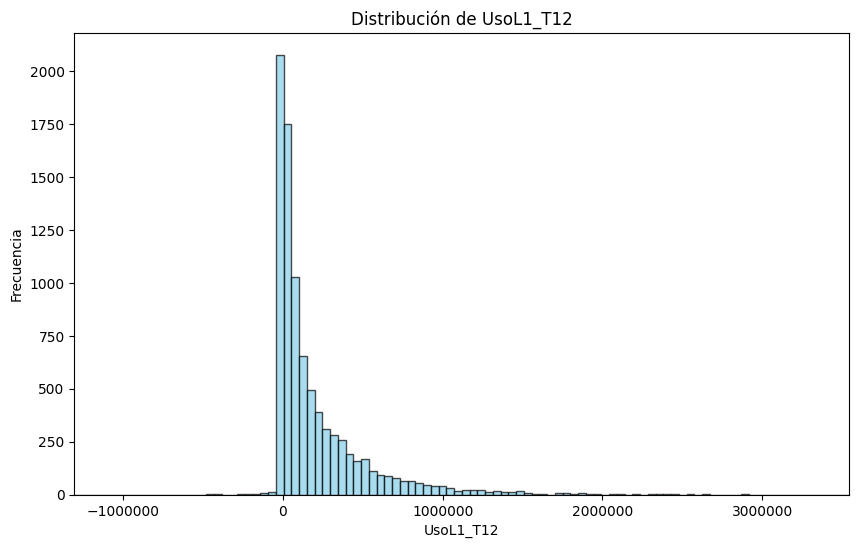

In [84]:
## Estadísticos de UsoL1_T12
casos_perdidos_UsoL1_T12 = df['UsoL1_T12'].isna().sum()
print(f'Casos perdidos en UsoL1_T12: {casos_perdidos_UsoL1_T12}')
UsoL1_T12 = df['UsoL1_T12']
media =UsoL1_T12.mean()
mediana = UsoL1_T12.median()
moda = UsoL1_T12.mode()[0]  # La moda puede tener más de un valor, se toma el primero
desviacion_estandar = UsoL1_T12.std()
varianza = UsoL1_T12.var()
valor_minimo = UsoL1_T12.min()
valor_maximo = UsoL1_T12.max()
percentil_25 = UsoL1_T12.quantile(0.25)
percentil_50 = UsoL1_T12.quantile(0.50)  #  mediana
percentil_75 = UsoL1_T12.quantile(0.75)
# Mostrar los resultados
print("Estadísticos descriptivos para la variable 'UsoL1_T12':")
print(f"Media: {media}")
print(f"Mediana: {mediana}")
print(f"Moda: {moda}")
print(f"Desviación Estándar: {desviacion_estandar}")
print(f"Varianza: {varianza}")
print(f"Valor Mínimo: {valor_minimo}")
print(f"Valor Máximo: {valor_maximo}")
print(f"Percentil 25: {percentil_25}")
print(f"Percentil 50 (Mediana): {percentil_50}")
print(f"Percentil 75: {percentil_75}")
print("-------------------------------------------------------")

## Histograma de UsoL1_T12

plt.figure(figsize=(10, 6))
plt.hist(UsoL1_T12, bins=100, color='skyblue', edgecolor='black',  alpha=0.7)  # Ajustar 'bins' según el nivel de detalle que desees

plt.title('Distribución de UsoL1_T12')
plt.xlabel('UsoL1_T12')
plt.ylabel('Frecuencia')
plt.xlim([valor_minimo, valor_maximo])
plt.ticklabel_format(style='plain', axis='x')
plt.show()

El análisis descriptivo de la variable UsoL1_T12 muestra una distribución con los siguientes aspectos clave:

* La media es 202,949.93, significativamente mayor que la mediana (75,564) y la moda (0.0), lo que indica una distribución sesgada hacia valores altos.
* La desviación estándar es alta (319,921.85), lo que refleja una gran variabilidad en los datos.
* Existe asimetría, pues mientras el 25% de los datos está por debajo de 7,092.0, el 75% se sitúa por debajo de 270,205.54.
* La presencia de los missing values se observa en la concentración en torno a valores bajos o nulos, resaltada por la diferencia marcada entre media y mediana.

La presencia de valores outliers y 1,245 casos perdidos implica el empleo de la transformación y limpieza de la variable.

# 3. Preparación de datos


En este momento, se llevará a cabo un proceso de preparación que incluye la identificación y tratamiento de outliers en las variables seleccionadas: EeccNac_T12, Fac_T12, UsoL1_T12 y Col_T12. Se Utilizará el método del rango intercuartílico (IQR) para detectar los valores atípicos. Primero, se calculará el primer cuartil (Q1) y el tercer cuartil (Q3) de cada variable, y luego se determinará el IQR. A partir de esto, se establecerán los límites inferior y superior para identificar los outliers, que serán convertidos a valores NaN en el nuevo DataFrame. Este proceso permitirá una mejor calidad de los datos y una análisis más robusto.

## 3.1 Transformación de datos para tratar outliers

In [85]:
variables_a_filtrar = ['EeccNac_T12', 'Fac_T12', 'UsoL1_T12', 'Col_T12']

for variable in variables_a_filtrar:
    print(f"DataFrame antes de convertir outliers a NaN para {variable}:")
    print(df[variable].describe())

    Q1 = df[variable].quantile(0.25)
    Q3 = df[variable].quantile(0.75)
    IQR = Q3 - Q1

    # Definir Q
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # Filtrar outliers
    df[f'{variable}_filtrado'] = df[variable].mask((df[variable] < limite_inferior) | (df[variable] > limite_superior))

    print('Datos NaN antes de filtrar outliers: ', df[variable].isnull().sum())
    print("===============================================")
    print(f"DataFrame después de convertir outliers a NaN para {variable}:")
    print(df[f'{variable}_filtrado'].describe())
    print('Datos NaN después de filtrar outliers: ', df[f'{variable}_filtrado'].isnull().sum())
    print("\n")

DataFrame antes de convertir outliers a NaN para EeccNac_T12:
count       8755.00
mean      211970.93
std       326148.11
min     -1303628.00
25%        17408.00
50%        86815.00
75%       271541.00
max      3529565.00
Name: EeccNac_T12, dtype: float64
Datos NaN antes de filtrar outliers:  1245
DataFrame después de convertir outliers a NaN para EeccNac_T12:
count      8012.00
mean     134040.44
std      158262.05
min     -359544.00
25%       13201.25
50%       70920.50
75%      204719.50
max      652482.00
Name: EeccNac_T12_filtrado, dtype: float64
Datos NaN después de filtrar outliers:  1988


DataFrame antes de convertir outliers a NaN para Fac_T12:
count      8755.00
mean      74667.45
std      141439.93
min      -39593.00
25%           0.00
50%       26217.00
75%       93885.00
max     4631740.59
Name: Fac_T12, dtype: float64
Datos NaN antes de filtrar outliers:  1245
DataFrame después de convertir outliers a NaN para Fac_T12:
count     8049.00
mean     44577.67
std      57272.5

## 3.2 Limpieza e imputación de datos

A continuación, se llevará a cabo un proceso de limpieza e imputación de datos para las variables filtradas: EeccNac_T12_filtrado, Fac_T12_filtrado, UsoL1_T12_filtrado y Col_T12_filtrado. Se utilizará el método de imputación basado en k-vecinos más cercanos (KNN) para abordar los valores perdidos en estas variables. Primero, se mostrará un resumen descriptivo de cada variable antes de la imputación, seguido de la creación de un imputador KNN con 5 vecinos. Luego, se realizará la imputación y se agregarán las variables imputadas al DataFrame original. Finalmente, se presentará un resumen descriptivo de cada variable después de la imputación y la cantidad de datos perdidos. Este procedimiento permitirá mejorar la integridad de los datos y facilitar un análisis posterior más preciso.

In [86]:
# Definir las variables a imputar
variables_a_imputar = ['EeccNac_T12_filtrado', 'Fac_T12_filtrado', 'UsoL1_T12_filtrado', 'Col_T12_filtrado', 'Region']

# Imputación de datos perdidos
for variable in variables_a_imputar:
    print(f"DataFrame antes de imputar para {variable}:")
    print(df[variable].describe())

    # Crear el imputador KNN
    imputer = KNNImputer(n_neighbors=5)

    # Preparar los datos para imputar, seleccionando solo las variables filtradas
    df_imputar = df[[variable]]

    # Realizar la imputación
    df_imputado = imputer.fit_transform(df_imputar)

    # Convertir el resultado a DataFrame
    df_variable_imputada = pd.DataFrame(df_imputado, columns=[f'{variable}_imputado'])

    # Agregar la variable imputada al DataFrame original
    df[f'{variable}_imputado'] = df_variable_imputada[f'{variable}_imputado']

    print("===============================================")
    print(f"DataFrame después de imputar para {variable}:")
    print(df[f'{variable}_imputado'].describe())
    print('Datos NaN: ', df[f'{variable}_imputado'].isnull().sum())
    print("\n")

DataFrame antes de imputar para EeccNac_T12_filtrado:
count      8012.00
mean     134040.44
std      158262.05
min     -359544.00
25%       13201.25
50%       70920.50
75%      204719.50
max      652482.00
Name: EeccNac_T12_filtrado, dtype: float64
DataFrame después de imputar para EeccNac_T12_filtrado:
count     10000.00
mean     134040.44
std      141658.24
min     -359544.00
25%       24410.00
50%      118744.00
75%      157116.00
max      652482.00
Name: EeccNac_T12_filtrado_imputado, dtype: float64
Datos NaN:  0


DataFrame antes de imputar para Fac_T12_filtrado:
count     8049.00
mean     44577.67
std      57272.50
min     -39593.00
25%          0.00
50%      20000.00
75%      70891.00
max     234504.00
Name: Fac_T12_filtrado, dtype: float64
DataFrame después de imputar para Fac_T12_filtrado:
count    10000.00
mean     44577.67
std      51382.10
min     -39593.00
25%          0.00
50%      40157.00
75%      55300.00
max     234504.00
Name: Fac_T12_filtrado_imputado, dtype: float6

Los resultados de la imputación muestran que el proceso fue exitoso para todas las variables analizadas (EeccNac_T12_filtrado, Fac_T12_filtrado, UsoL1_T12_filtrado y Col_T12_filtrado), ya que no se registraron datos faltantes en las variables imputadas.  La imputación ha permitido llenar los valores perdidos en todas las variables, mejorando la cantidad de datos disponibles para el análisis y ajustando los valores centrales y la variabilidad. Estos cambios sugieren que la imputación ha tenido un impacto positivo en la calidad de los datos.

Lo anterior se puede observar al generar boxplots con las variables características en la fase previa a la transformación e imputación, y la posterior. Anteriormente, no se podía representar los datos de las variables mediante el gráfico de caja por los problemas que presentaban. Actualmente, esto se resuelve generándose los boxplots. Sin embargo, es relevante señalar que aparecieron un número importante de observaciones outliers.

In [89]:
# Crear boxplots para cada variable
plt.figure(figsize=(16, 20))

# Boxplot para EeccNac_T12
plt.subplot(4, 1, 1)
plt.boxplot(df['EeccNac_T12'], vert=False)
plt.title('Boxplot de EeccNac_T12 original con casos nulos')
plt.xlabel('EeccNac_T12')
plt.ticklabel_format(style='plain', axis='x')
plt.grid()

# Boxplot para EeccNac_T12 imputado
plt.subplot(4, 1, 2)
plt.boxplot(df['EeccNac_T12_filtrado_imputado'], vert=False)
plt.title('Boxplot de EeccNac_T12 imputado')
plt.xlabel('EeccNac_T12 imputado')
plt.ticklabel_format(style='plain', axis='x')
plt.grid()

In [90]:
plt.figure(figsize=(16, 20))

# Boxplot para Fac_T12
plt.subplot(4, 1, 1)
plt.boxplot(df['Fac_T12'], vert=False)
plt.title('Boxplot de Fac_T12 original con casos nulos')
plt.xlabel('Fac_T12')
plt.ticklabel_format(style='plain', axis='x')
plt.grid()

# Boxplot para Fac_T12 imputado
plt.subplot(4, 1, 2)
plt.boxplot(df['Fac_T12_filtrado_imputado'], vert=False)
plt.title('Boxplot de Fac_T12 imputado')
plt.xlabel('Fac_T12 imputado')
plt.ticklabel_format(style='plain', axis='x')
plt.grid()

In [91]:
plt.figure(figsize=(16, 24))
# Boxplot para UsoL1_T12
plt.subplot(4, 1, 1)
plt.boxplot(df['UsoL1_T12'], vert=False)
plt.title('Boxplot de UsoL1_T12 original con casos nulos')
plt.xlabel('UsoL1_T12')
plt.ticklabel_format(style='plain', axis='x')
plt.grid()

plt.subplot(4, 1, 2)
plt.boxplot(df['UsoL1_T12_filtrado_imputado'], vert=False)
plt.title('Boxplot de UsoL1_T12 imputado')
plt.xlabel('UsoL1_T12 imputado')
plt.ticklabel_format(style='plain', axis='x')
plt.grid()


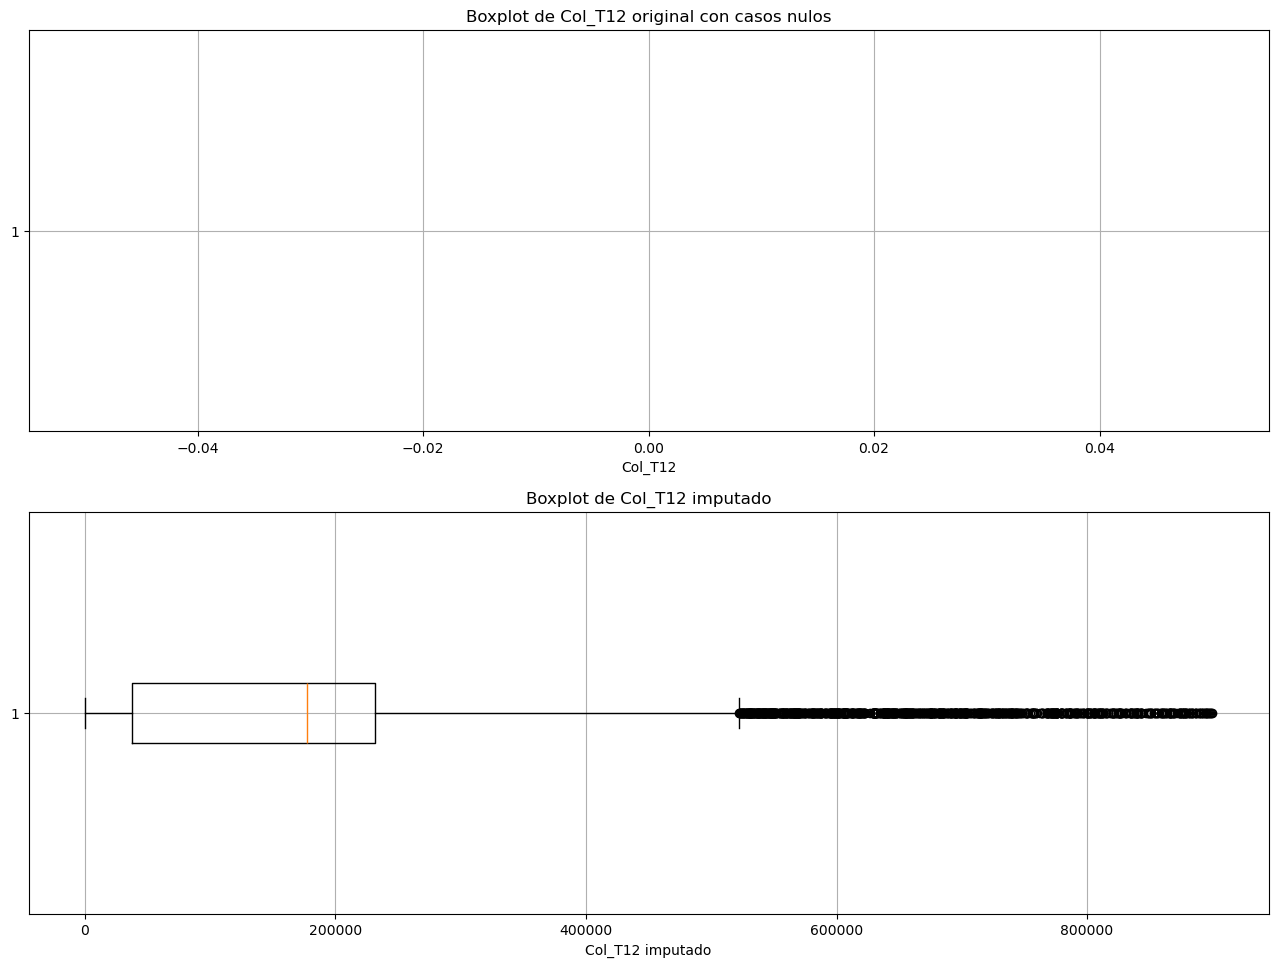

In [101]:
plt.figure(figsize=(16, 24))
# Boxplot para Col_T12
plt.subplot(4, 1, 1)
plt.boxplot(df['Col_T12'], vert=False)
plt.title('Boxplot de Col_T12 original con casos nulos')
plt.xlabel('Col_T12')
plt.ticklabel_format(style='plain', axis='x')
plt.grid()

plt.subplot(4, 1, 2)
plt.boxplot(df['Col_T12_filtrado_imputado'], vert=False)
plt.title('Boxplot de Col_T12 imputado')
plt.xlabel('Col_T12 imputado')
plt.ticklabel_format(style='plain', axis='x')
plt.grid()

### 3.3 Normalización de variables características

La normalización sirve para ajustar las características numéricas de los datos en una escala común, lo cual es crucial en ciertos modelos de aprendizaje automático, especialmente aquellos que calculan distancias entre los puntos de datos. En este caso, resulta fundamenta realizar este proceso para ajustar de manera óptima las predicciones hacia la variable target.

In [92]:
features_normalizadas = ['EeccNac_T12_filtrado_imputado', 
                          'Fac_T12_filtrado_imputado', 
                          'UsoL1_T12_filtrado_imputado', 
                          'Col_T12_filtrado_imputado']

variables_a_normalizar = features_normalizadas

# Objeto para estadizar o normalizar

scaler = StandardScaler()

# Normalización 

df[features_normalizadas] = scaler.fit_transform(df[variables_a_normalizar])
print(df[features_normalizadas].head())

   EeccNac_T12_filtrado_imputado  Fac_T12_filtrado_imputado  \
0                           0.00                       0.21   
1                           0.78                      -0.48   
2                          -0.28                       1.54   
3                           1.59                      -0.00   
4                           0.70                       1.82   

   UsoL1_T12_filtrado_imputado  Col_T12_filtrado_imputado  
0                         0.00                       2.52  
1                         0.79                       0.94  
2                        -0.24                      -0.34  
3                         1.58                       0.80  
4                        -0.43                      -0.06  


## 4. Selección de características

En esta fase, se procederá a la selección de características para identificar y retener las variables más relevantes que contribuyen a la explicación de la variabilidad en el conjunto de datos. El objetivo es reducir la dimensionalidad del conjunto de datos y mejorar la eficiencia y efectividad de los modelos de análisis posteriores. La técnica a utilizar es la Correlación de Pearson.

### 4.1 Análisis de correlaciones entre features


Matriz de correlación:
                                EeccNac_T12_filtrado_imputado  \
EeccNac_T12_filtrado_imputado                           1.00   
Fac_T12_filtrado_imputado                               0.15   
UsoL1_T12_filtrado_imputado                             0.90   
Col_T12_filtrado_imputado                               0.63   

                               Fac_T12_filtrado_imputado  \
EeccNac_T12_filtrado_imputado                       0.15   
Fac_T12_filtrado_imputado                           1.00   
UsoL1_T12_filtrado_imputado                         0.17   
Col_T12_filtrado_imputado                           0.16   

                               UsoL1_T12_filtrado_imputado  \
EeccNac_T12_filtrado_imputado                         0.90   
Fac_T12_filtrado_imputado                             0.17   
UsoL1_T12_filtrado_imputado                           1.00   
Col_T12_filtrado_imputado                             0.65   

                               Col_T12_filt

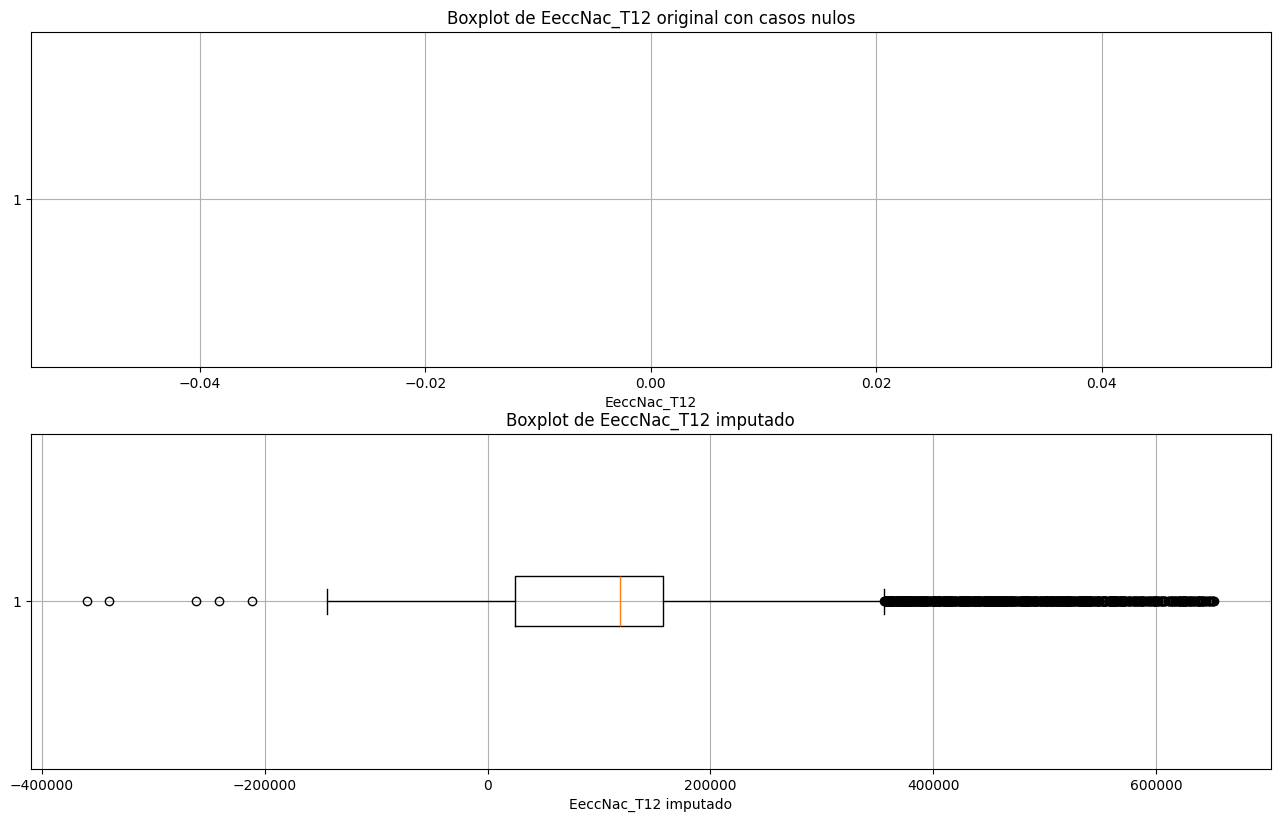

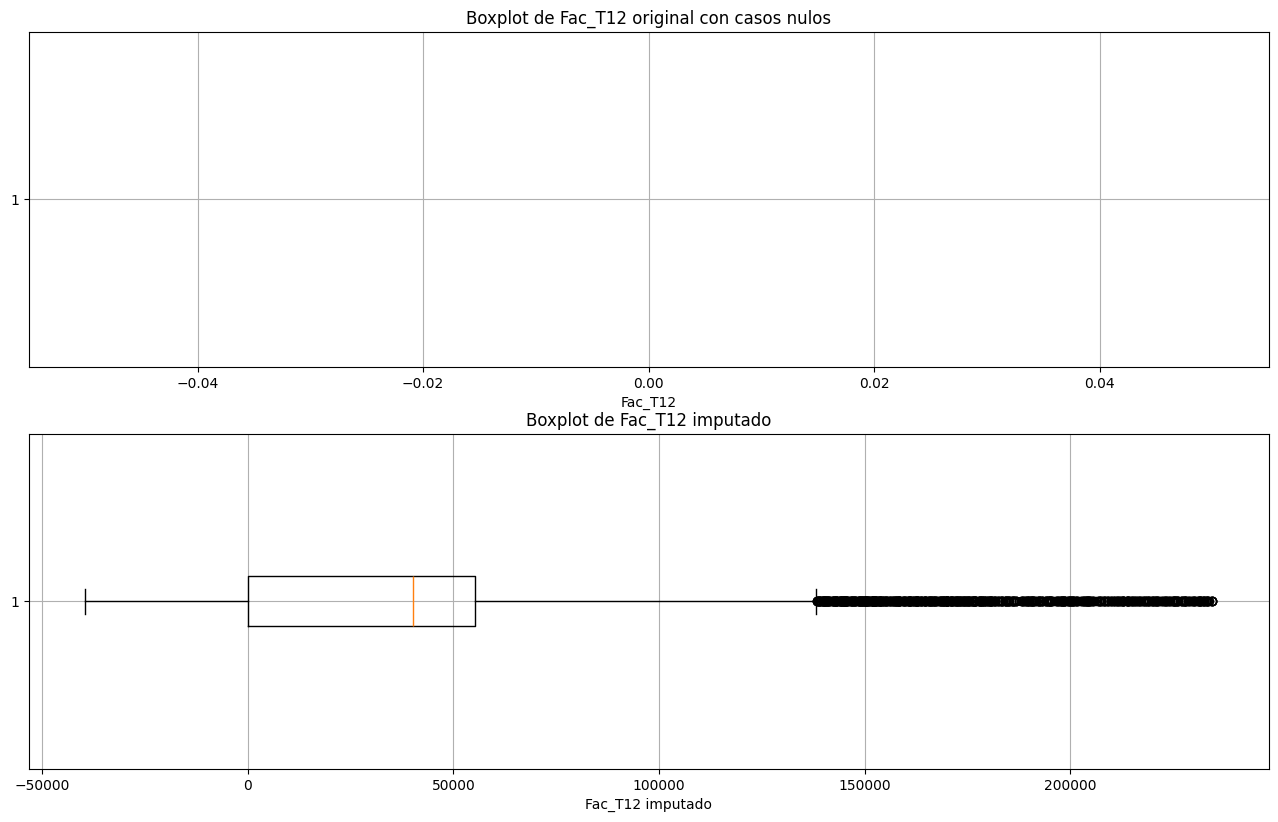

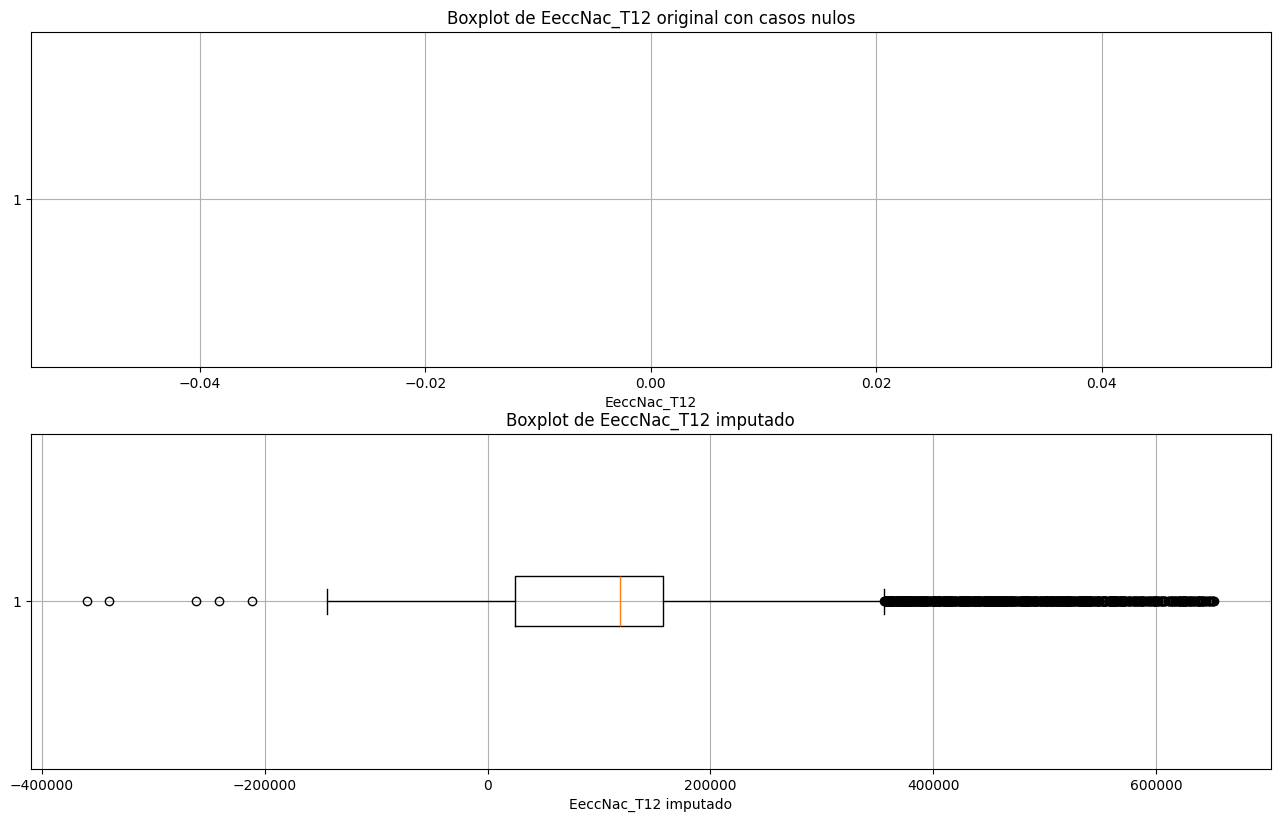

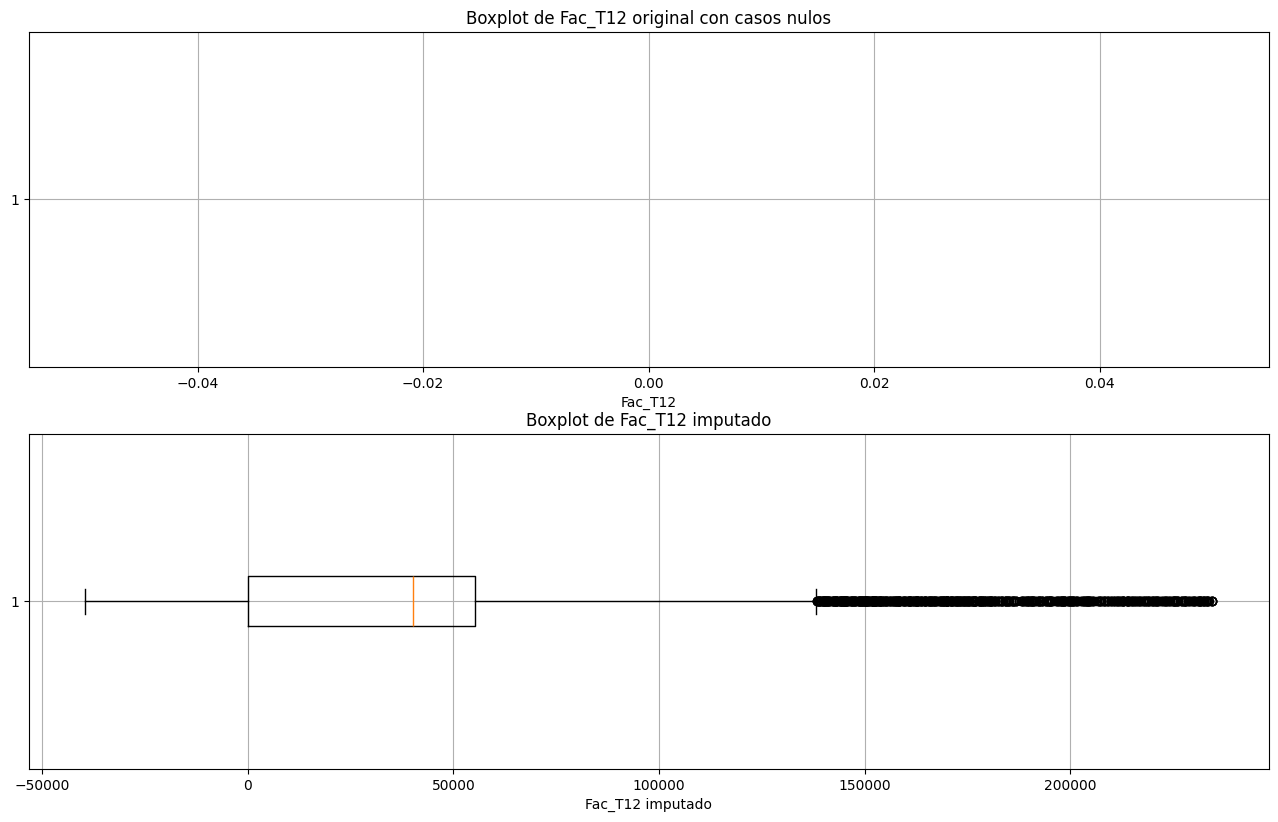

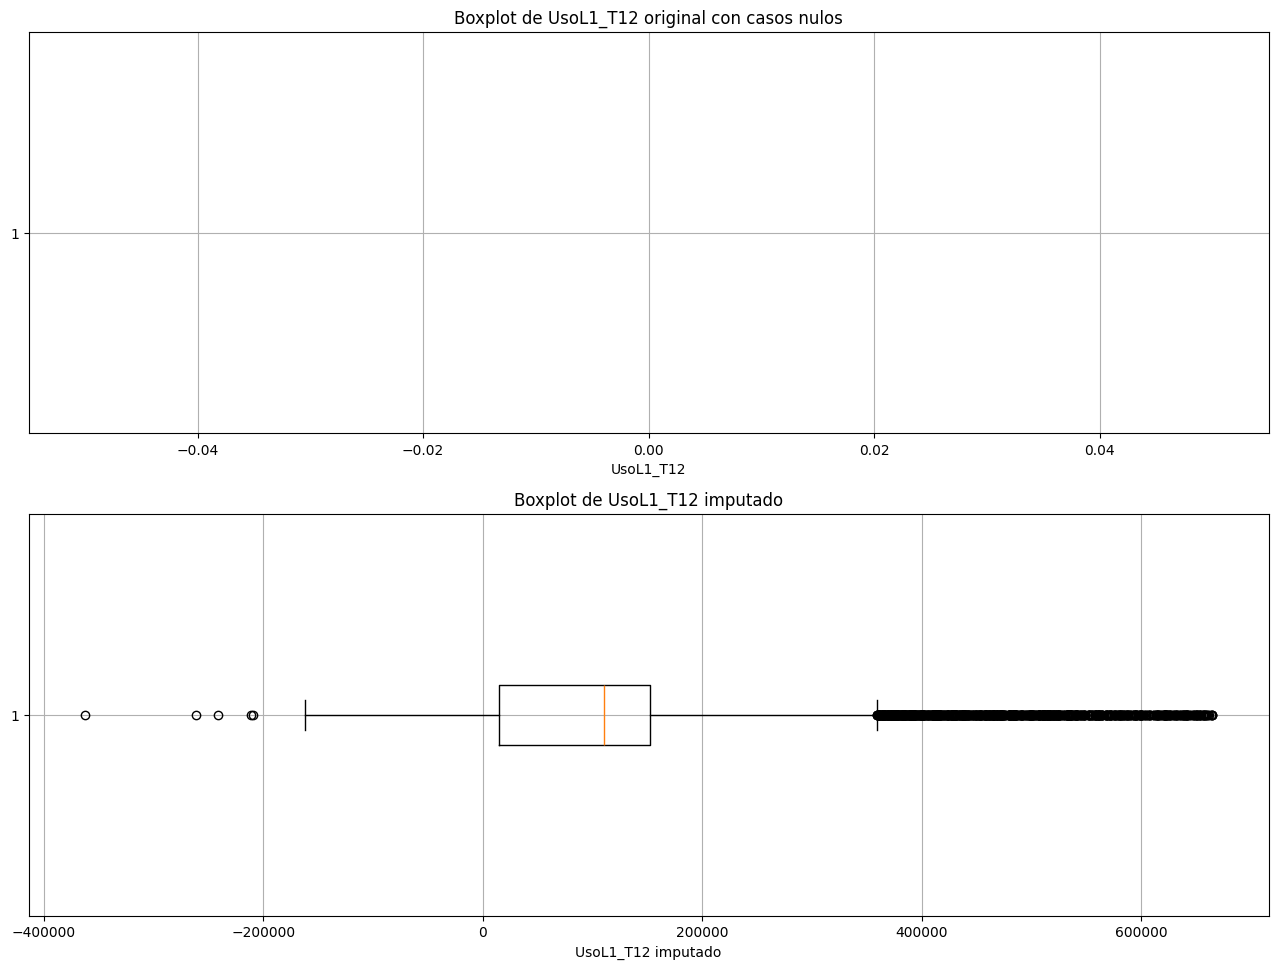

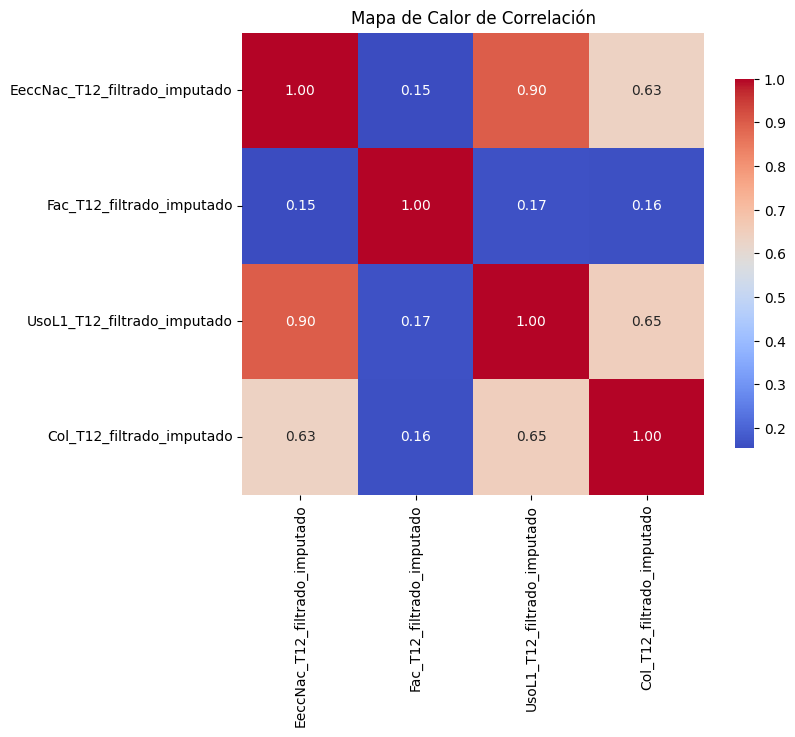

In [93]:
## Correlaciones
correlation_matrix = df[features_normalizadas].corr(method='pearson')


print("Matriz de correlación:\n", correlation_matrix)

## Gráfico de mapa de color

# Tamaño de la figura
plt.figure(figsize=(8, 6))

# Mapa de calor
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, 
             xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.index)

# Título
plt.title('Mapa de Calor de Correlación')

# Mostrar el gráfico
plt.show()

El análisis de correlación revela que EeccNac_T12_filtrado_imputado y UsoL1_T12_filtrado_imputado son las variables más fuertemente relacionadas. Si bien esto puede parecer positivo para la mejora posterior del rendimiento de los modelos, se debe tener en cuenta el problema de la multicolinealidad (que afecta también a modelos de clasificación).

Las correlaciones moderadas entre Col_T12_filtrado_imputado y las otras variables también son dignas de mención, mientras que Fac_T12_filtrado_imputado presenta interacciones más débiles, sugiriendo que podría ser menos relevante en este contexto.

Al presentarse estos hallazgos, se empleará Backward Selection para la reducción de las variables, con el fin de dar mayor consistencia al proceso de selección de características.

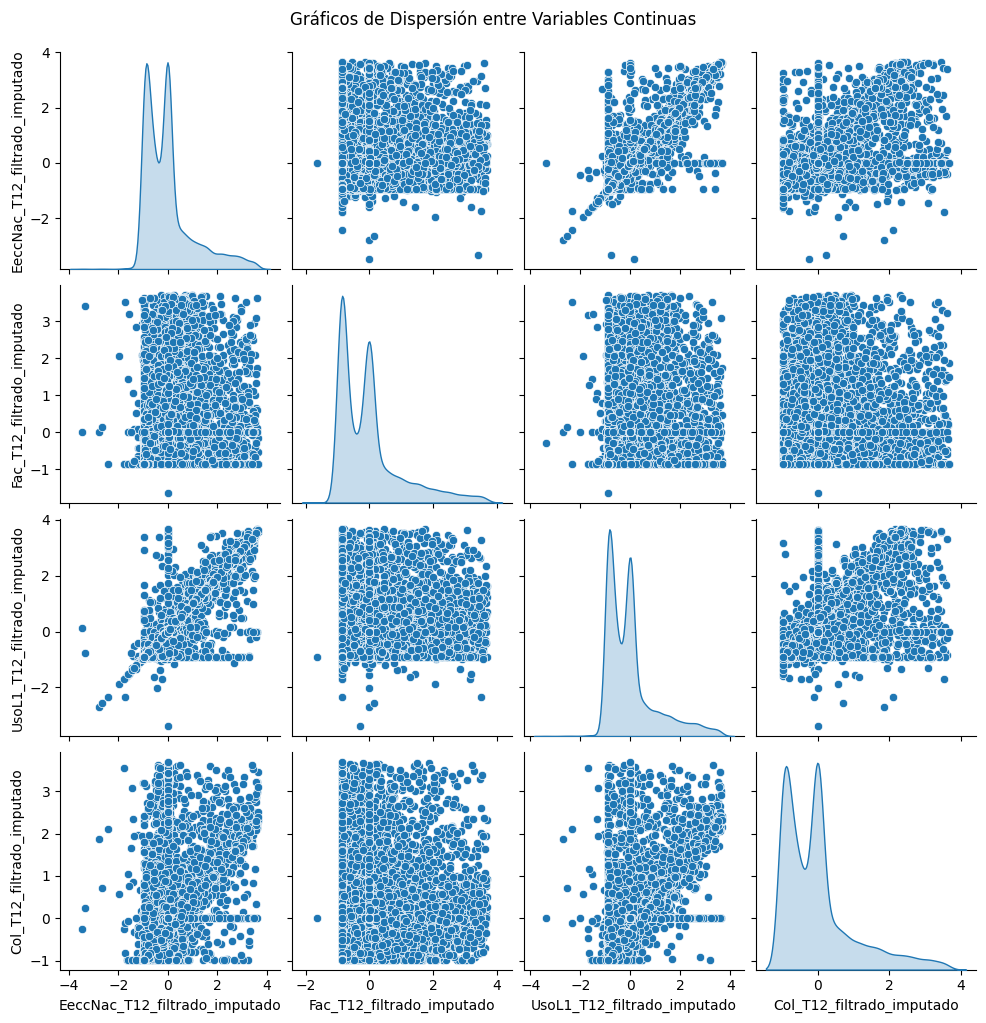

In [94]:
continuous_vars = df[['EeccNac_T12_filtrado_imputado', 
                      'Fac_T12_filtrado_imputado', 
                      'UsoL1_T12_filtrado_imputado', 
                      'Col_T12_filtrado_imputado']]

# Pairplot
sns.pairplot(continuous_vars, diag_kind='kde')  # diag_kind='kde' muestra la densidad en la diagonal
plt.suptitle('Gráficos de Dispersión entre Variables Continuas', y=1.02)  # Título para el gráfico
plt.show()

En este momento, se va a revisar la correlación de 'Region' y 'Sexo' para evaluar la posibilidad de emplear estas variables en el modelo. Se empleará la prueba de chi-cuadrado.

In [95]:
contingency_table3 = pd.crosstab(df['Sexo'], df['Region'])

# Calcular el estadístico Chi-cuadrado
chi2, p, dof, expected = chi2_contingency(contingency_table3)

# Calcular el coeficiente de Phi
phi = np.sqrt(chi2 / df.shape[0])

print("Coeficiente de Phi:", phi)

Coeficiente de Phi: 0.050731578813950726


Si bien se puede afirmar que no existe una relación entre Sexo y Región, hay una cercanía al dígito que permite establecer la hipótesis de existencia de relación. Esto puede ayudar la predicciones de los modelos que se generarán, pues no se observa colinealidad pero si una tendencia de cercanía entre estas características.

### 4.2 Análisis de Componentes Principales (PCA)

El Análisis de Componentes Principales (PCA) es una técnica para reducir la dimensionalidad de los datos, manteniendo la mayor cantidad posible de varianza.

In [96]:
# Features
variables_modelo_no_supervisado = [
    'EeccNac_T12_filtrado_imputado',
    'Fac_T12_filtrado_imputado',
    'UsoL1_T12_filtrado_imputado',
    'Col_T12_filtrado_imputado',
]

# PCA

pca = PCA(n_components=len(variables_modelo_no_supervisado))
data_to_fit = df[variables_modelo_no_supervisado].values 
pca.fit(data_to_fit)

# Visalizar varianza explicada

explained_variance = pca.explained_variance_ratio_

# Print de la varianza explicada de cada componente

print("Varianza explicada por componente:", explained_variance)



Varianza explicada por componente: [0.62836905 0.23752188 0.10937085 0.02473822]


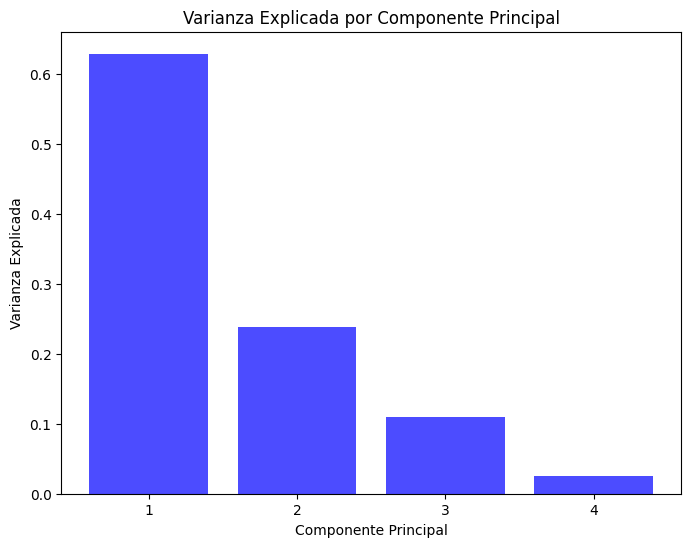

In [97]:
# Gráfico de varianza explicada
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(variables_modelo_no_supervisado) + 1), explained_variance, alpha=0.7, color='b', align='center')
plt.ylabel('Varianza Explicada')
plt.xlabel('Componente Principal')
plt.title('Varianza Explicada por Componente Principal')
plt.xticks(range(1, len(variables_predictoras) + 1))
plt.show()


La varianza explicada por cada componente principal que obtuviste es la siguiente:

* PC1: 62.8%
* PC2: 23.8%
* PC3: 10.9%
* PC4: 2.5%

Según estos datos, se puede indicar que PC1 captura el 62.8% de la varianza total en los datos, lo que significa que este componente es el que más información sobre las características originales retiene. Después, PC2 captura el 62.8% de la varianza total en los datos, lo que significa que este componente es el que más información sobre las características originales retiene. Por último PC3 y PC4 explican menos de un 13% de la varianza en total, lo que indica que las primeras dos componentes ya están capturando la mayor parte de la información relevante.

Esto sugiere que, si se desea reducir las dimensiones de los datos sin perder mucha información, los modelos pueden centrarse en los primeros dos componentes principales (PC1 y PC2), que en conjunto explican aproximadamente un 86.6% de la varianza total. No obstante, para la generación de los modelos se va usar 3 componentes para ver elaborar modelos que permitan visualizar agrupamientos más explícitos que con sólo dos cluster.

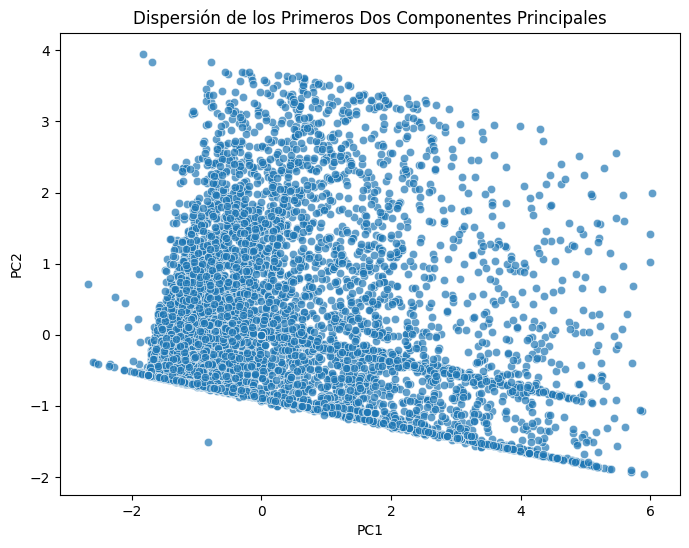

In [98]:
# Proyección de los datos a los componentes principales
principal_components = pca.transform(data_to_fit)

# Crear un DataFrame con las componentes principales
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])

# Gráfico de dispersión de los primeros dos componentes principales
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], alpha=0.7)
plt.title('Dispersión de los Primeros Dos Componentes Principales')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## 5. Modelado

### 5.1 Selección de técnica de modelado

La selección de técnicas de modelado no supervisado, como K-Means, K-Medoids, DBSCAN y el clustering jerárquico, se justifica tanto desde un punto de vista teórico como práctico, especialmente cuando trabajamos con datos que aún no tienen etiquetas, algo que es común en muchos proyectos de análisis de datos, como cuando se buscan patrones ocultos o segmentaciones dentro de un conjunto grande de información.

Desde un enfoque teórico, las técnicas de clustering permiten organizar datos en grupos basados en sus similitudes, sin la necesidad de etiquetas predefinidas. Esto contrasta con los modelos supervisados, donde las etiquetas o la variable dependiente están predefinidas y el modelo aprende a predecir esas etiquetas a partir de los datos. En un escenario como el presentado, en el que se hace un análisis sin una variable target explícita, las técnicas de clustering no supervisado son ideales para explorar los datos y generar insights sobre la estructura subyacente.

K-Means, por ejemplo, es un modelo muy eficiente y ampliamente utilizado debido a su simplicidad y rapidez. Al trabajar con dos o tres clústeres, es fácil identificar patrones y segmentaciones lógicas que podrían tener aplicaciones en el análisis de comportamiento de usuarios o segmentación de mercados. Sin embargo, su rendimiento depende de que los clústeres sean de forma esférica y de la correcta elección de la cantidad de clústeres. K-Medoids, al ser más robusto frente a outliers, se adapta mejor a situaciones en las que los datos tienen ruido o valores atípicos, lo que lo convierte en una alternativa más robusta en la segmentación, como se observa en los altos Silhouette Scores de tus pruebas.

Por otro lado, DBSCAN ofrece la ventaja de ser menos sensible a la cantidad de clústeres, ya que permite la detección de zonas de alta densidad en los datos. Esto lo hace útil cuando se desconoce la cantidad exacta de grupos, y sus capacidades para manejar el "ruido" (outliers) lo convierten en una técnica útil para situaciones más complejas, como las que uno podría enfrentar en proyectos con datos no estructurados o distribuidos irregularmente. Sin embargo, la elección de los parámetros como eps puede ser crucial para su rendimiento.

Finalmente, el clustering jerárquico, aunque es intuitivo y produce una estructura más visual, a menudo no es tan efectivo cuando los clústeres no tienen una estructura jerárquica clara o cuando el número óptimo de clústeres no es evidente.

**En resumen, el uso de estas técnicas no supervisadas, basadas en la exploración y segmentación de datos sin etiquetas, permite descubrir patrones sin tener que depender de una variable target. A diferencia de los modelos supervisados, que requieren una variable dependiente para aprender las relaciones, los métodos no supervisados son ideales para generar segmentaciones, detectar anomalías o simplemente explorar la estructura del conjunto de datos.**


### 5.2 Selección de datos para modelos no supervisados

In [116]:
# Definir las variables del modelo
variables_modelo_no_supervisado = [
    'EeccNac_T12_filtrado_imputado', 
    'Fac_T12_filtrado_imputado', 
    'UsoL1_T12_filtrado_imputado', 
    'Col_T12_filtrado_imputado'
]

# Seleccionar las características del DataFrame
df_modelo_no_supervisado = df[variables_modelo_no_supervisado]


### 5.3 Ejecución de modelos

#### 5.3.1 K-Means

##### Etapa 1: Modelo con dos componentes

Inercia de K-Means:  22630.85009745916
Silhouette Score:  0.5126992391186189


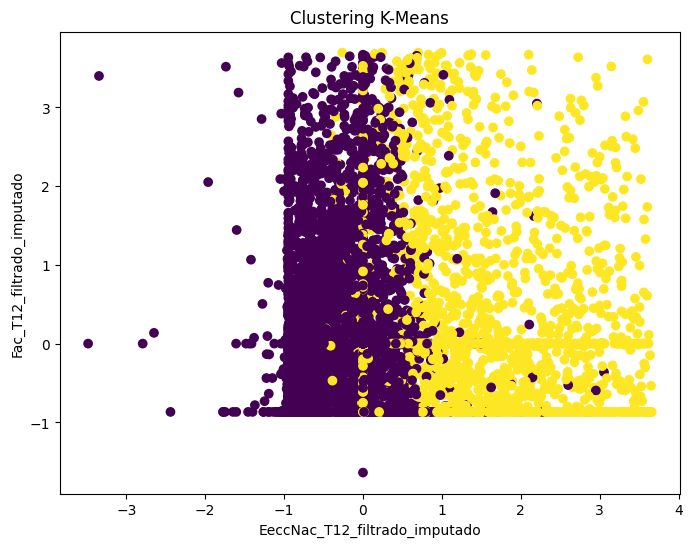

In [169]:
# Ajuste del modelo K-Means con el número de clusters deseado (por ejemplo, 2 clusters)
kmeans = KMeans(n_clusters=2, random_state=42)
df['Cluster'] = kmeans.fit_predict(df[variables_modelo_no_supervisado])

# Visualizar la inercia (suma de errores cuadráticos dentro de los clusters)
print("Inercia de K-Means: ", kmeans.inertia_)

# Calcular el Silhouette Score (un valor entre -1 y 1, donde un valor cercano a 1 indica que los clusters están bien definidos)
sil_score = silhouette_score(df[variables_modelo_no_supervisado], df['Cluster'])
print("Silhouette Score: ", sil_score)

# Visualización de los clusters (usando los dos primeros componentes principales)
plt.figure(figsize=(8, 6))
plt.scatter(df[variables_modelo_no_supervisado[0]], df[variables_modelo_no_supervisado[1]], c=df['Cluster'], cmap='viridis')
plt.title('Clustering K-Means')
plt.xlabel(variables_modelo_no_supervisado[0])
plt.ylabel(variables_modelo_no_supervisado[1])
plt.show()

__Resultados obtenidos:__


* Inercia de K-Means: 22630.850: La inercia es un indicador de qué tan compactos son los clusters. En general, una inercia más baja es mejor, pero este valor por sí solo no es suficiente para juzgar el modelo sin tener otros puntos de comparación, como el Silhouette Score.
* Silhouette Score: 0.52. El Silhouette Score indica la calidad del clustering, y este con un valor de 0.52 se puede indicar que existe una estructura clara. No obstante, pueen haber ligeros solapamientos entre algunos agrupamientos. Idealmente, debería estar más cerca de 1, lo que indicaría que los clusters están bien definidos. Un valor cercano a 0 sugiere que los clusters están relativamente cerca unos de otros o que el número de clusters no es adecuado para la estructura de los datos. Un valor negativo indicaría que los puntos están en el cluster equivocado.

Si bien el ACP se indico la preferencia por dos clústeres, se va a hacer una prueba con 3 agrupamientos. Esto para establecer una estructura de agrupamientos que permitan definir grupos sin caer en un resultado binario que sea demasiado categórico para un análisis.

##### Etapa 2: Modelo con tres componentes

Inercia de K-Means:  17181.545205490915
Silhouette Score:  0.3658481715240798


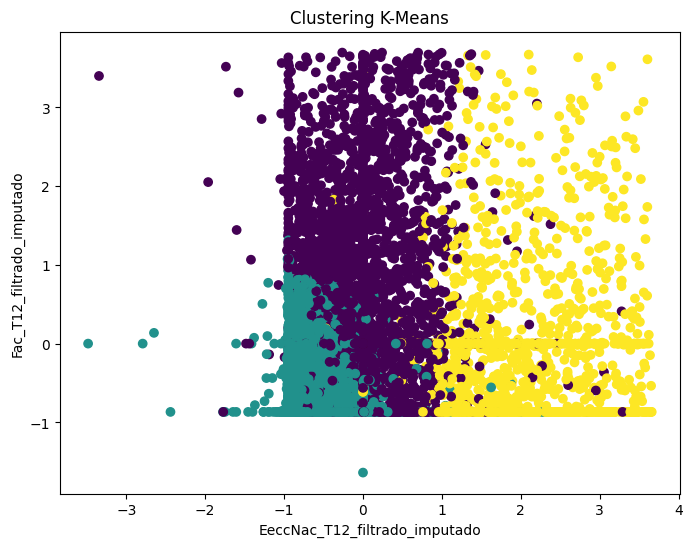

In [192]:
# Ajuste del modelo K-Means con el número de clusters deseado 
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(df[variables_modelo_no_supervisado])

# Visualizar la inercia (suma de errores cuadráticos dentro de los clusters)
print("Inercia de K-Means: ", kmeans.inertia_)

# Calcular el Silhouette Score (un valor entre -1 y 1, donde un valor cercano a 1 indica que los clusters están bien definidos)
sil_score = silhouette_score(df[variables_modelo_no_supervisado], df['Cluster'])
print("Silhouette Score: ", sil_score)

# Visualización de los clusters (usando los dos primeros componentes principales)
plt.figure(figsize=(8, 6))
plt.scatter(df[variables_modelo_no_supervisado[0]], df[variables_modelo_no_supervisado[1]], c=df['Cluster'], cmap='viridis')
plt.title('Clustering K-Means')
plt.xlabel(variables_modelo_no_supervisado[0])
plt.ylabel(variables_modelo_no_supervisado[1])
plt.show()

__Resultados obtenidos:__

* Inercia de K-Means: 17181.545. Este valor de inercia es menor que el de la prueba con 2 clústeres (22,630.85), lo que indica que, al agregar un clúster adicional, el modelo está logrando una partición más ajustada de los datos. Sin embargo, el cambio en la inercia no es drástico, lo que sugiere que los nuevos clústeres no están mejorando significativamente la estructura de los datos. Es posible que el modelo esté dividiendo los clústeres de manera forzada, lo que podría no ser óptimo.
* Silhouette Score: 0.365. Este valor es más bajo que el obtenido con 2 clústeres (0.51). El Silhouette Score indica la calidad de la agrupación. Un valor de 0.37 aprox. sugiere que los clústeres son más difusos o que hay más solapamiento entre ellos. Esto puede señalar que algunos puntos están más cerca del centro de clústeres ajenos. Por lo tanto, la elección de 3 clústeres puede no ser adecuada para la estructura real de los datos.


#### 5.3.2 Modelo K-Medoids

##### Etapa 1: Modelo con dos clústeres

In [208]:
# Datos 
data = df_modelo_no_supervisado.values

# N° de Clusters
n_clusters = 2

In [209]:
# Seleccionar los índices de los puntos medoids iniciales (se puede seleccionar aleatoriamente)
initial_medoids = [0, 100]  

# Crear el objeto kmedoids con los datos y los medoids iniciales
kmedoids_instance = kmedoids(data, initial_medoids)

# Ejecutar el algoritmo
kmedoids_instance.process()

# Obtener los clústeres asignados y los medoids
clusters = kmedoids_instance.get_clusters()
medoids = kmedoids_instance.get_medoids()

# Imprimir los resultados
print(f"Medoids: {medoids}")


# Mostrar los datos de los medoids
medoid_data = df_modelo_no_supervisado.iloc[medoids]
print("Datos de los Medoids:")
print(medoid_data)

Medoids: [277, 6794]
Datos de los Medoids:
      EeccNac_T12_filtrado_imputado  Fac_T12_filtrado_imputado  \
277                            0.00                       0.50   
6794                           0.65                       2.14   

      UsoL1_T12_filtrado_imputado  Col_T12_filtrado_imputado  cluster  \
277                          0.00                       0.00        3   
6794                         0.33                       0.44        3   

      dbscan_cluster  
277                2  
6794              42  


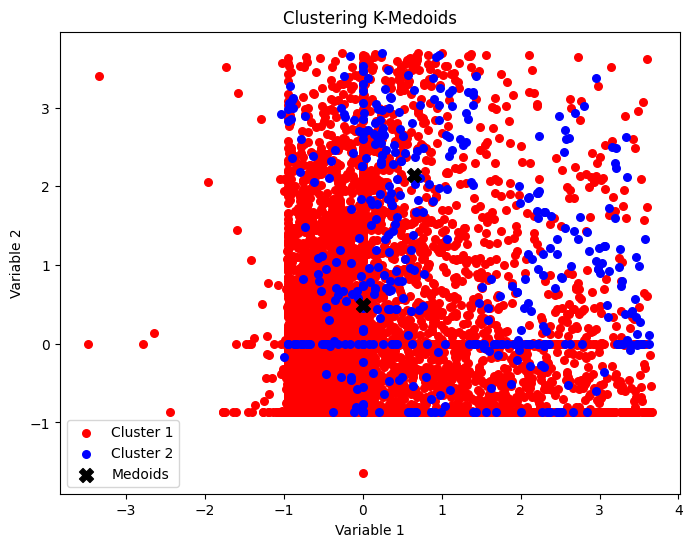

In [210]:
# Visualización de los clusters y los medoids
plt.figure(figsize=(8, 6))

# Asignar colores a los diferentes clústeres
colors = ['red', 'blue', 'green']

for i, cluster in enumerate(clusters):
    cluster_data = np.array([data[j] for j in cluster])
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], s=30, c=colors[i], label=f'Cluster {i+1}')

# Mostrar los medoids
medoids_data = np.array([data[medoid] for medoid in medoids])
plt.scatter(medoids_data[:, 0], medoids_data[:, 1], s=100, c='black', marker='X', label='Medoids')

plt.title('Clustering K-Medoids')
plt.xlabel('Variable 1')
plt.ylabel('Variable 2')
plt.legend()
plt.show()

In [211]:
# Obtener las etiquetas de los clústeres a partir de los resultados de K-Medoids
labels = [-1] * len(df_modelo_no_supervisado)  # Inicializa una lista con -1 (sin clúster)
for cluster_id, cluster in enumerate(clusters):
    for idx in cluster:
        labels[idx] = cluster_id  # Asigna el ID del clúster a cada punto

# Silhouette Score
from sklearn.metrics import silhouette_score
sil_score = silhouette_score(df_modelo_no_supervisado, labels)
print(f"Silhouette Score: {sil_score}")


Silhouette Score: 0.8707408975313833


__Resultado obtenidos:__

* Los medoids 277 y 6794 actúan como los centros del clúster y representan ejemplos reales de los datos, lo que hace que K-Medoids sea menos sensible a valores atípicos en comparación con K-Means. La diferencia según características puede indicar una distinción marcada de grupos en la estructura de datos.
* El Silhouette Score de 0.87 es significativamente mejor que los resultados obtenidos previamente con K-Means (0.51 para 2 clústeres y 0.37 para 3 clústeres). Esto indica que los clústeres están mejor definidos y se encuentran cercanos al mejor valor, que sería 1.
* La estructura de los datos es captada eficazmente mediante dos agrupamiento, lo que puede indicar una separación inherente de los datos en dos clusters. Además, este modelo resulta ser robusto frente a los valores atípicos y otras características del dataset.

##### Etapa 2: Modelo con tres clústeres

In [204]:
# Datos 
data = df_modelo_no_supervisado.values

# N° de Clusters
n_clusters = 3

# Seleccionar los índices de los puntos medoids iniciales (se puede seleccionar aleatoriamente)
initial_medoids = [0, 100, 200]  

# Crear el objeto kmedoids con los datos y los medoids iniciales
kmedoids_instance = kmedoids(data, initial_medoids)

# Ejecutar el algoritmo
kmedoids_instance.process()

# Obtener los clústeres asignados y los medoids
clusters = kmedoids_instance.get_clusters()
medoids = kmedoids_instance.get_medoids()

# Imprimir los resultados
print(f"Medoids: {medoids}")

Medoids: [5425, 6794, 508]


In [207]:
# Mostrar los datos de los medoids
medoid_data = df_modelo_no_supervisado.iloc[medoids]
print("Datos de los Medoids:")
print(medoid_data)

Datos de los Medoids:
      EeccNac_T12_filtrado_imputado  Fac_T12_filtrado_imputado  \
5425                           0.41                       0.09   
6794                           0.65                       2.14   
508                           -0.64                      -0.38   

      UsoL1_T12_filtrado_imputado  Col_T12_filtrado_imputado  cluster  \
5425                         0.43                       0.49        4   
6794                         0.33                       0.44        3   
508                         -0.60                      -0.61        1   

      dbscan_cluster  
5425               1  
6794              42  
508                5  


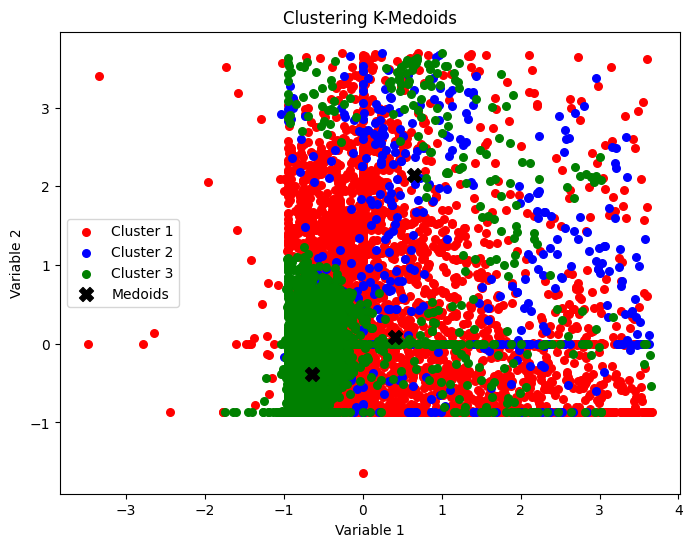

In [205]:
# Visualización de los clusters y los medoids
plt.figure(figsize=(8, 6))

# Asignar colores a los diferentes clústeres
colors = ['red', 'blue', 'green']

for i, cluster in enumerate(clusters):
    cluster_data = np.array([data[j] for j in cluster])
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], s=30, c=colors[i], label=f'Cluster {i+1}')

# Mostrar los medoids
medoids_data = np.array([data[medoid] for medoid in medoids])
plt.scatter(medoids_data[:, 0], medoids_data[:, 1], s=100, c='black', marker='X', label='Medoids')

plt.title('Clustering K-Medoids')
plt.xlabel('Variable 1')
plt.ylabel('Variable 2')
plt.legend()
plt.show()

In [215]:
# Obtener las etiquetas de los clústeres a partir de los resultados de K-Medoids
labels = [-1] * len(df_modelo_no_supervisado)  # Inicializa una lista con -1 (sin clúster)
for cluster_id, cluster in enumerate(clusters):
    for idx in cluster:
        labels[idx] = cluster_id  # Asigna el ID del clúster a cada punto

# Silhouette Score
from sklearn.metrics import silhouette_score
sil_score = silhouette_score(df_modelo_no_supervisado, labels)
print(f"Silhouette Score: {sil_score}")


Silhouette Score: 0.8797479188742976


__Resultado obtenidos:__

* Los medoids 5425, 6794, y 508 actúan como los centros del clúster y representan ejemplos reales de los datos. Los dos primeros son cercanos en algunos dimensiones, sumando el tercero se distintgue claramente de los otros dos al contar con valores negativos. La cercanía de 5425 y 6794 puede representr la disminución en el Silhouette Score.
* El Silhouette Score de 0.67 es menor que la prueba con dos agrupamientos, pero sigue siendo superior a lo obtenido del modelo K-means. En este sentido, el puntaje sigue razonablemente alto y responde a una conformación de clústers moderadamente bien definidios. 
* Agregar un tercer clúster ha disminuido la claridad de la separación, lo cual es común cuando se aumenta el número de clústeres. Podría indicar que 2 clústeres representan una estructura más natural, mientras que 3 clústeres están capturando una segmentación más sutil o artificial.



#### 5.3.3 Clustering jerárquico

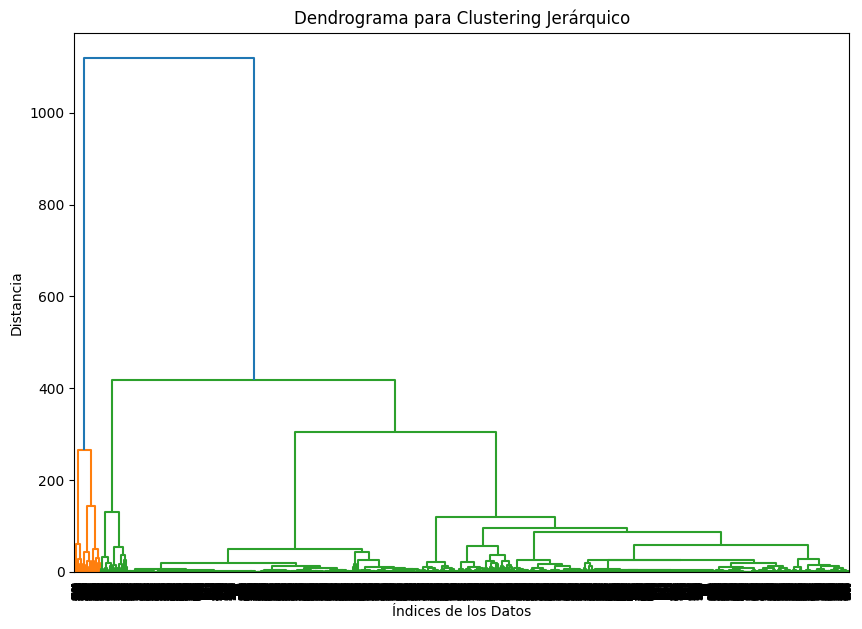

In [221]:
# Usar el método 'ward' para minimizar la varianza dentro de los clústeres
Z = linkage(df_modelo_no_supervisado, method='ward')

# Dendrograma
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title("Dendrograma para Clustering Jerárquico")
plt.xlabel("Índices de los Datos")
plt.ylabel("Distancia")
plt.show()

##### Etapa 1: Modelo con dos clusters

In [217]:
from scipy.cluster.hierarchy import fcluster

# Definir el número de clústeres
num_clusters = 2
labels = fcluster(Z, num_clusters, criterion='maxclust')

# Añadir las etiquetas de clúster a tu DataFrame
df_modelo_no_supervisado.loc[:, 'cluster'] = labels

sil_score = silhouette_score(df_modelo_no_supervisado.iloc[:, :-1], labels)
print(f"Silhouette Score: {sil_score}")

print(df_modelo_no_supervisado[['EeccNac_T12_filtrado_imputado', 'Fac_T12_filtrado_imputado', 
                                'UsoL1_T12_filtrado_imputado', 'Col_T12_filtrado_imputado', 
                                'cluster']])

Silhouette Score: 0.34408081613821684
      EeccNac_T12_filtrado_imputado  Fac_T12_filtrado_imputado  \
0                              0.00                       0.21   
1                              0.78                      -0.48   
2                             -0.28                       1.54   
3                              1.59                      -0.00   
4                              0.70                       1.82   
...                             ...                        ...   
9995                           0.00                       0.00   
9996                          -0.95                      -0.87   
9997                           0.00                       0.00   
9998                           0.07                      -0.46   
9999                          -0.95                      -0.87   

      UsoL1_T12_filtrado_imputado  Col_T12_filtrado_imputado  cluster  
0                            0.00                       2.52        2  
1                        

##### Etapa 2: Modelo con tres clusters

In [219]:
# Definir el número de clústeres
num_clusters = 3
labels = fcluster(Z, num_clusters, criterion='maxclust')

# Añadir las etiquetas de clúster a tu DataFrame
df_modelo_no_supervisado.loc[:, 'cluster'] = labels

sil_score = silhouette_score(df_modelo_no_supervisado.iloc[:, :-1], labels)
print(f"Silhouette Score: {sil_score}")

print(df_modelo_no_supervisado[['EeccNac_T12_filtrado_imputado', 'Fac_T12_filtrado_imputado', 
                                'UsoL1_T12_filtrado_imputado', 'Col_T12_filtrado_imputado', 
                                'cluster']])

Silhouette Score: 0.37055755422136033
      EeccNac_T12_filtrado_imputado  Fac_T12_filtrado_imputado  \
0                              0.00                       0.21   
1                              0.78                      -0.48   
2                             -0.28                       1.54   
3                              1.59                      -0.00   
4                              0.70                       1.82   
...                             ...                        ...   
9995                           0.00                       0.00   
9996                          -0.95                      -0.87   
9997                           0.00                       0.00   
9998                           0.07                      -0.46   
9999                          -0.95                      -0.87   

      UsoL1_T12_filtrado_imputado  Col_T12_filtrado_imputado  cluster  
0                            0.00                       2.52        3  
1                        

##### Etapa 3: Modelo con tres clusters

In [220]:
# Definir el número de clústeres
num_clusters = 4
labels = fcluster(Z, num_clusters, criterion='maxclust')

# Añadir las etiquetas de clúster a tu DataFrame
df_modelo_no_supervisado.loc[:, 'cluster'] = labels

sil_score = silhouette_score(df_modelo_no_supervisado.iloc[:, :-1], labels)
print(f"Silhouette Score: {sil_score}")

print(df_modelo_no_supervisado[['EeccNac_T12_filtrado_imputado', 'Fac_T12_filtrado_imputado', 
                                'UsoL1_T12_filtrado_imputado', 'Col_T12_filtrado_imputado', 
                                'cluster']])

Silhouette Score: 0.31994441762795034
      EeccNac_T12_filtrado_imputado  Fac_T12_filtrado_imputado  \
0                              0.00                       0.21   
1                              0.78                      -0.48   
2                             -0.28                       1.54   
3                              1.59                      -0.00   
4                              0.70                       1.82   
...                             ...                        ...   
9995                           0.00                       0.00   
9996                          -0.95                      -0.87   
9997                           0.00                       0.00   
9998                           0.07                      -0.46   
9999                          -0.95                      -0.87   

      UsoL1_T12_filtrado_imputado  Col_T12_filtrado_imputado  cluster  
0                            0.00                       2.52        4  
1                        

##### __Resultados obtenidos__:

* 2 clústeres (0.344):
Este puntaje indica que los clústeres están algo separados, pero hay un cierto grado de solapamiento entre ellos. Esto puede ser útil si se busca una segmentación simple, pero podría no capturar toda la estructura de los datos.
* 3 clústeres (0.371):
Este puntaje es ligeramente superior, lo que sugiere que 3 clústeres podrían estar capturando mejor las estructuras presentes en los datos. Es el mejor resultado obtenido.
* 4 clústeres (0.320):
Con 4 clústeres, el puntaje disminuye, lo que indica que agregar más clústeres no mejora la separación entre grupos y podría introducir ruido o clasificaciones menos claras.

Según los datos obtenidos, los 3 clústeres parece ser la mejor opción, ya que tiene el mejor puntaje de Silhouette Score (0.371). Esto implica que los datos tienen una estructura donde tres grupos son representativos. La disminución del puntaje con 4 clústeres sugiere que dividir demasiado los datos genera clústeres que no son significativamente diferentes o están menos cohesionados internamente.

#### 5.3.4 Modelo DBSCAN

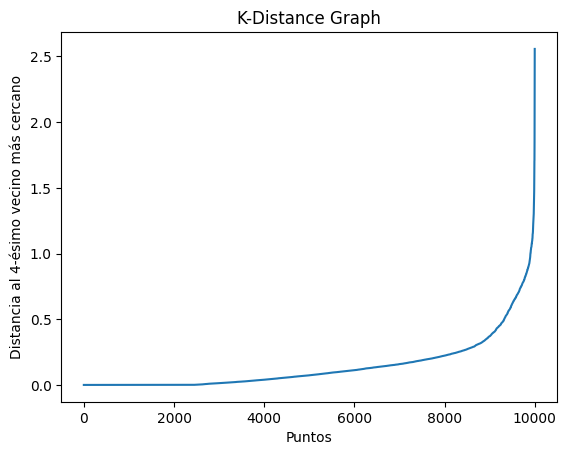

In [222]:
from sklearn.neighbors import NearestNeighbors

# Usar k=4 para encontrar el 4to vecino más cercano
k = 4
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(df_modelo_no_supervisado)
distances, indices = neighbors_fit.kneighbors(df_modelo_no_supervisado)

# Ordenar las distancias de cada punto a su k-ésimo vecino más cercano
distances = np.sort(distances[:, k-1], axis=0)

# Graficar el gráfico de distancias
plt.plot(distances)
plt.title("K-Distance Graph")
plt.xlabel("Puntos")
plt.ylabel(f"Distancia al {k}-ésimo vecino más cercano")
plt.show()

Silhouette Score para DBSCAN: 0.6095890777485816


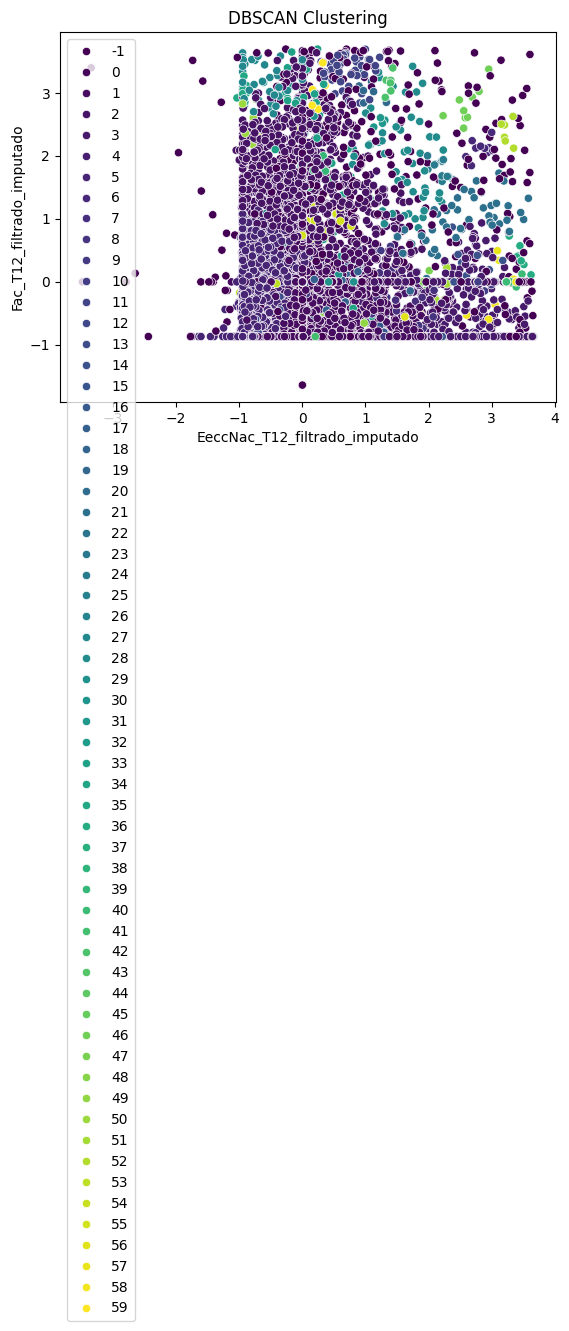

In [223]:
# Definir el modelo DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  #eps de 0,5 por Codo de gráfico anterior de K-distancias

# Aplicar el modelo a los datos
labels_dbscan = dbscan.fit_predict(df_modelo_no_supervisado)

# Añadir las etiquetas de clúster a tu DataFrame
df_modelo_no_supervisado.loc[:,'dbscan_cluster'] = labels_dbscan

# Evaluar la calidad del clustering usando el Silhouette Score
sil_score_dbscan = silhouette_score(df_modelo_no_supervisado, labels_dbscan)
print(f"Silhouette Score para DBSCAN: {sil_score_dbscan}")

# Visualizar los clústeres (si tienes solo dos o tres dimensiones en tus datos)
sns.scatterplot(x=df_modelo_no_supervisado['EeccNac_T12_filtrado_imputado'],
                y=df_modelo_no_supervisado['Fac_T12_filtrado_imputado'],
                hue=labels_dbscan, palette='viridis', legend='full')
plt.title("DBSCAN Clustering")
plt.show()

__Resultado obtenido:__

El Silhouette Score de 0.609 para DBSCAN es bastante sólido y comparable a los mejores resultados obtenidos, como el de K-Medoids con 2 clústeres (0.871). Este puntaje sugiere que DBSCAN logró identificar clústeres bien separados y cohesivos, aunque el método tiende a etiquetar puntos como ruido si no cumplen con los parámetros de densidad. Este punto le resta fuerza a la posibilidad de elegir este modelo para este proyecto.

## 6. Evaluación

### 6.1 Revisión preliminar

| Modelo                | Número de Clústeres | Silhouette Score | Inercia        | Observaciones                                      |
|-----------------------|---------------------|------------------|----------------|----------------------------------------------------|
| **K-Medoids**          | 2                   | 0.871            | -              | Alta separación y cohesión. Mejor rendimiento.     |
| **K-Medoids**          | 3                   | 0.606            | -              | Menor cohesión, menor separación entre los clústeres. |
| **K-Means**            | 2                   | 0.513            | 22630.85       | Buena separación, pero no tan definida como K-Medoids. |
| **K-Means**            | 3                   | 0.366            | 17181.55       | Baja cohesión, más solapamiento entre clústeres.   |
| **DBSCAN**             | -                   | 0.610            | -              | Buen desempeño, útil si hay ruido o clústeres no esféricos. |
| **Clustering Jerárquico** | 2                 | 0.344            | -              | Baja separación, clústeres mal definidos.          |
| **Clustering Jerárquico** | 3                 | 0.371            | -              | Mejor que 2, pero sigue sin ser adecuado.          |
| **Clustering Jerárquico** | 4                 | 0.320            | -              | La calidad empeora, más solapamiento.              |


* K-Medoids con 2 clústeres (Silhouette Score: 0.871) muestra el mejor rendimiento, indicando una clara separación y cohesión en los clústeres. Es una opción fuerte si buscas clústeres bien definidos y coherentes.
* DBSCAN también tiene un Silhouette Score alto de 0.610, lo que lo convierte en una buena opción, especialmente si tus datos tienen ruido o clústeres no esféricos.
* K-Means con 2 clústeres (Silhouette Score: 0.513) es una opción decente. El Silhouette Score es moderado, lo que sugiere que los clústeres están razonablemente separados pero no tan definidos como en el caso de K-Medoids.
* K-Means con 3 clústeres (Silhouette Score: 0.366) muestra una caída notable en la calidad del modelo, lo que indica que 3 clústeres no están mejorando la separación de los datos y puede haber solapamientos.
* Clustering Jerárquico presenta resultados variados dependiendo del número de clústeres:

    * 2 clústeres: Silhouette Score bajo (0.344), lo que indica una mala separación.
    * 3 clústeres: Mejora ligeramente (0.371), pero sigue siendo insuficiente.
    * 4 clústeres: La calidad empeora aún más (0.320), lo que sugiere que un número mayor de clústeres no es adecuado para estos datos.

### 6.2 Elección de modelo

Al evaluar los diferentes modelos de clustering, se observa que K-Medoids con 2 clústeres ofrece el mejor rendimiento con un Silhouette Score de 0.871, lo que indica una buena separación y cohesión entre los clústeres. Este modelo tiene una excelente capacidad para identificar grupos bien definidos, lo que lo convierte en una opción sólida para este conjunto de datos. Es importante que este resultado se ciñe a lo indicado al Análisis de Componentes principales.

Por otro lado, DBSCAN también muestra un desempeño bastante bueno con un Silhouette Score de 0.610. Es especialmente útil cuando se tiene ruido o clústeres no esféricos, lo que hace que este modelo sea adecuado si se quiere capturar estructuras más complejas en los datos.

K-Means, con 2 clústeres, obtuvo un Silhouette Score de 0.513, lo que indica una separación aceptable, aunque no tan pronunciada como la de K-Medoids. Sin embargo, su desempeño disminuye con 3 clústeres, donde el Silhouette Score cae a 0.366, sugiriendo un solapamiento mayor entre los clústeres.

Finalmente, el clustering jerárquico presenta los resultados más bajos. Con 2 clústeres, el Silhouette Score es de 0.344, y empeora aún más al aumentar los clústeres. Esto sugiere que la estructura de los datos no se adapta bien a este tipo de modelo.

En resumen, K-Medoids con 2 clústeres es la opción más recomendable para este conjunto de datos debido a su capacidad para separar y definir claramente los grupos. Si el conjunto de datos tiene ruido o formas no esféricas, DBSCAN también es una alternativa válida.

### 6.4 Conclusiones de la evaluación

Tras evaluar los diferentes modelos de clustering, se pueden extraer varias conclusiones clave sobre el rendimiento y la adecuación de cada uno al conjunto de datos:

* K-Medoids (2 clústeres): Este modelo presentó el mejor rendimiento general con un Silhouette Score de 0.871. Esto sugiere que los clústeres generados son altamente coherentes internamente y están bien separados entre sí. Esto es particularmente importante si se busca una segmentación clara y precisa. K-Medoids es menos sensible a los valores atípicos que K-Means y tiene una mejor capacidad para identificar clústeres no esféricos, lo que lo convierte en una opción robusta para este caso.

* DBSCAN: Con un Silhouette Score de 0.610, DBSCAN muestra una capacidad moderada para detectar clústeres, aunque su desempeño es algo inferior al de K-Medoids. Sin embargo, DBSCAN tiene la ventaja de ser capaz de manejar ruido y clústeres de forma arbitraria (no esféricos). Aunque su rendimiento no es tan alto como el de K-Medoids, es útil cuando se enfrentan datos con ruido o formas complejas.

* K-Means: Al trabajar con 2 clústeres, K-Means mostró un Silhouette Score de 0.513, indicando que los clústeres están razonablemente separados, pero con una cohesión algo menor que en K-Medoids. A medida que se aumenta el número de clústeres a 3, el Silhouette Score disminuye a 0.366, sugiriendo que el modelo está creando clústeres que se solapan más entre sí, lo que podría reflejar una segmentación menos precisa.

* Clustering Jerárquico: Este modelo presentó los peores resultados, con Silhouette Scores de 0.344 (2 clústeres), 0.371 (3 clústeres) y 0.320 (4 clústeres). Esto indica que el modelo jerárquico no logra capturar bien la estructura de los datos, lo que sugiere que este tipo de clustering no es adecuado para los datos actuales, ya que no es capaz de definir grupos bien separados.

El modelo K-Medoids con 2 clústeres es el más adecuado para este conjunto de datos debido a su alta precisión en la segmentación, lo que se refleja en su excelente Silhouette Score. Además, su capacidad para manejar de manera efectiva los clústeres de forma arbitraria lo hace ideal para este escenario. DBSCAN también es una opción válida, especialmente si se desea manejar datos con ruido o clústeres de formas complejas, aunque su rendimiento es ligeramente inferior. En cambio, K-Means y el clustering jerárquico no son tan efectivos en este caso, especialmente al aumentar el número de clústeres.